# Experimentation to assess the prevision potential of the generative part of VAEs

## Loading libraries

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [4]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
from FeaturesScore.exploration import *

#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

In [5]:
import CVAE.cvae_model
import CVAE.cvae_model_mixture
import CVAE.cvae_model_cluster
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.cvae_model_mixture)
importlib.reload(CVAE.cvae_model_cluster)
%load_ext autoreload
%autoreload

## Shapping the data

In [313]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset_2012_2017.csv")
x_conso = pd.read_csv(dataset_csv, sep=",").rename(columns={'conso_final':'consumption_France_final'})
x_conso.ds = pd.to_datetime(x_conso.ds)
x_conso_2018 = pd.read_csv(path_data+"/dataset_2018.csv").rename(columns={'consommation_france':'consumption_France_final', 'temperature':'temperature_France', 'prev_J_1':'day_ahead'})
x_conso_2018.ds = pd.to_datetime(x_conso_2018.ds)
x_conso_2018['temperature_France'].interpolate(method='linear',inplace=True)

In [46]:
x_conso_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
ds                          17520 non-null datetime64[ns]
consumption_France_final    17520 non-null float64
is_holiday_day              17520 non-null int64
day_ahead                   17520 non-null float64
temperature_France          2915 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 684.5 KB


In [47]:
x_conso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87830 entries, 0 to 87829
Data columns (total 6 columns):
ds                          87830 non-null datetime64[ns]
consumption_France          87830 non-null float64
temperature_France          87830 non-null float64
is_holiday_day              87830 non-null float64
consumption_France_final    87830 non-null float64
day_ahead                   87830 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.0 MB


In [48]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

In [293]:
dict_xconso = {'train': x_conso[['ds','consumption_France_final', 'temperature_France', 'is_holiday_day', 'day_ahead']], 'test':x_conso_2018[['ds','consumption_France_final', 'temperature_France', 'is_holiday_day', 'day_ahead']]}

In [294]:
# Normalize input variables
dict_xconso, scaler = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France_final']


In [301]:
dict_xconso['train'].describe()

consumption_France_final  temperature_France  is_holiday_day  \
count              8.783000e+04        87830.000000    87830.000000   
mean              -2.588793e-18           12.639393        0.030058   
std                1.000006e+00            6.706958        0.170748   
min               -2.085285e+00           -4.714150        0.000000   
25%               -7.620740e-01            7.452313        0.000000   
50%               -1.347014e-01           12.238112        0.000000   
75%                7.029703e-01           17.484106        0.000000   
max                3.316839e+00           33.451400        1.000000   

          day_ahead  
count  87830.000000  
mean      -0.025392  
std        0.992972  
min       -2.166786  
25%       -0.782032  
50%       -0.156390  
75%        0.661115  
max        3.388913

In [298]:
for key in dict_xconso.keys():
    dict_xconso[key].day_ahead = scaler.transform(dict_xconso[key].day_ahead.values.reshape(-1,1))

In [297]:
dict_xconso['test'].describe()

consumption_France_final  temperature_France  is_holiday_day  \
count              17520.000000        17520.000000    17520.000000   
mean                  -0.014300           13.601335        0.030137   
std                    1.023949            7.209035        0.170969   
min                   -2.004286           -5.505780        0.000000   
25%                   -0.801385            8.061061        0.000000   
50%                   -0.173283           12.945993        0.000000   
75%                    0.721740           19.333143        0.000000   
max                    3.514792           33.843662        1.000000   

          day_ahead  
count  17520.000000  
mean   53884.910959  
std    12118.745988  
min    30300.000000  
25%    44600.000000  
50%    52000.000000  
75%    62500.000000  
max    95400.000000

In [299]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)
type_cond = ['day', 'weekday']
dataset_cond = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=type_cond)

day (1830, 7)
weekday (1830, 1)
day (365, 7)
weekday (365, 1)


In [300]:
dataset_all_cond = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=['day','weekday', 'month', 'temperature','is_holiday'])

day (1830, 7)
weekday (1830, 1)
month (1830, 12)
temperature (1830, 48)
is_holiday (1830, 1)
day (365, 7)
weekday (365, 1)
month (365, 12)
temperature (365, 48)
is_holiday (365, 1)


In [59]:
#importation des données calendaires
calendar_info={}
for key in dataset.keys():
    calendar_info[key] = pd.DataFrame(dataset[key]['ds'])
    calendar_info[key]['month'] = calendar_info[key].ds.dt.month
    calendar_info[key]['weekday'] = calendar_info[key].ds.dt.weekday
    calendar_info[key]['is_weekday'] = (calendar_info[key].weekday < 5).apply(lambda x:int(x))
    if key == 'train':
        calendar_info[key] = pd.merge(calendar_info[key], x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
    else:
        calendar_info[key] = pd.merge(calendar_info[key], x_conso_2018[['ds', 'is_holiday_day']], on='ds', how ='left')
    calendar_info[key].loc[calendar_info[key]['is_holiday_day'].isna(),'is_holiday_day'] = 0
    calendar_info[key]['year'] = calendar_info[key].ds.dt.year
    
    day_hol = calendar_info[key][['weekday', 'is_holiday_day']].copy().values
    bridge_index=[]
    for i in range(day_hol.shape[0]):
        if day_hol[i,1]==1:
            if day_hol[i,0]==1:
                bridge_index.append(i-1)
            elif day_hol[i,0]==3:
                bridge_index.append(i+1)

    bridges = np.zeros(day_hol.shape[0])
    bridges[np.asarray(bridge_index)] = 1

    calendar_info[key]['potential_bridge_holiday'] = bridges

In [66]:
calendar_info['train'].describe()

month      weekday   is_weekday  is_holiday_day         year  \
count  1830.000000  1830.000000  1830.000000     1830.000000  1830.000000   
mean      6.535519     3.003279     0.713661        0.030055  2014.993989   
std       3.455188     2.000817     0.452173        0.170784     1.419796   
min       1.000000     0.000000     0.000000        0.000000  2012.000000   
25%       4.000000     1.000000     0.000000        0.000000  2014.000000   
50%       7.000000     3.000000     1.000000        0.000000  2015.000000   
75%      10.000000     5.000000     1.000000        0.000000  2016.000000   
max      12.000000     6.000000     1.000000        1.000000  2017.000000   

       potential_bridge_holiday  
count               1830.000000  
mean                   0.008743  
std                    0.093121  
min                    0.000000  
25%                    0.000000  
50%                    0.000000  
75%                    0.000000  
max                    1.000000

In [62]:
#importation des données météo
meteo1_csv = os.path.join(path_data, "meteo_events.csv")
meteo2_csv = os.path.join(path_data, "meteo_events_2.csv")

meteo_events1 = pd.read_csv(meteo1_csv)
meteo_events2 = pd.read_csv(meteo2_csv)
meteo_events = meteo_events1.append(meteo_events2)
events = ['snow', 'floods', 'storm', 'hurricane', 'heavy_rains', 'cold', 'hot']
meteo_records=pd.DataFrame(data=np.zeros((nPoints, len(events))), columns=events)
from datetime import *
for k in range(meteo_events.shape[0]):
    day = datetime.strptime(meteo_events.iloc[k,0],'%Y-%m-%d')
    cld = np.asarray(calendar_info['train'].ds.dt.date)
    row = np.where(cld==day.date())[0]
    meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])
    duration = int(meteo_events.iloc[k,1])
    if duration != 0:
        for i in range(duration):
            day_inc = timedelta(days=i+1)+day
            cld = np.asarray(calendar_info['train'].ds.dt.date)
            row = np.where(cld==day_inc.date())[0]
            meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])

meteo_records.iloc[:,:] = 1*(meteo_records.iloc[:,:]>0)

In [314]:
factorMatrix={}
for key in calendar_info.keys():
    if key =='train' :
        xconso = x_conso
    else:
        xconso=x_conso_2018
    factors = calendar_info[key].iloc[:,1:5].copy()
    columns_x = xconso.columns
    conso_idx = np.argmax(['consumption' in c for c in xconso.columns])
    temp_idx = np.argmax(['temperature' in c for c in xconso.columns])
    dates = np.unique(xconso['ds'].dt.date)
    temperatureMean=np.asarray([np.nanmean(xconso[columns_x[temp_idx]].iloc[np.where(xconso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

    factorMatrix[key] = np.c_[factors.values,temperatureMean]

factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'temperature':'regressor',
}

## Tools for evaluation

In [67]:
#visualisation des metriques
def display_metrics(model_eval, z_dim, factorDesc):
    if 'reconstruction_error' in model_eval.keys():
        for k,v in model_eval['reconstruction_error'].item():
            print(k, ' : ', v)
    print('Mutual Information Gap : %.2f'%model_eval['mig'])

    fig = plt.figure(dpi=100,figsize=(10,8))

    plt.subplot(1, 3, 1)
    fig.subplots_adjust(hspace=0.5)
    plt.bar(factorDesc.keys(),model_eval['informativeness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.ylim(top=1)
    for index,data in enumerate(model_eval['informativeness']):
        plt.text(x=index - 0.5, y =data+0.01 , s="%.2f"%data , fontdict=dict(fontsize=10))
    plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']))

    plt.subplot(1, 3, 2)
    plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
    plt.xlabel('latent variables')
    plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

    plt.subplot(1, 3, 3)
    plt.bar(factorDesc.keys(),model_eval['compactness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.title('Compactness')
    plt.tight_layout();

In [68]:
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded, factorMatrix):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,4], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

In [463]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle

def display_loads(list_x,date,scaler):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    x = scaler.inverse_transform(list_x[0])
    x_hat = [scaler.inverse_transform(x_hat) for x_hat in list_x[1:]]
    plt.plot(x, label = 'truth')
    for j,x_hat in enumerate(x_hat):
        plt.plot(x_hat, '--', label = 'reconstruction_{}'.format(j))
    plt.title(date)
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

In [70]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

# Etude de la série temporelle

In [75]:
ts = x_conso[['ds','consumption_France_final']].copy()

In [205]:
def moving_average(x, periods=3):
    weights = np.ones(periods) / periods
    #left=np.asarray([np.convolve(np.roll(x[:(2*periods)],-periods), np.concatenate((np.zeros(periods-i),np.ones(periods)/periods)),mode='same')[periods+i] for i in range(int(periods/2))])
    #right=np.asarray([np.convolve(np.roll(x[-(2*periods)::-1],-periods), np.concatenate((np.zeros(periods-i),np.ones(periods)/periods)),mode='same')[periods+i] for i in range(int(periods/2))])[::-1]
    convo = np.convolve(x, weights, mode='same')
    impact_range = int(periods/2)
    mean_convo=np.mean(convo)
    denom = np.arange(0,impact_range,step=1)+1
    convo[:impact_range] = (convo[:impact_range] * periods + mean_convo*denom[::-1]) / periods
    convo[-impact_range:] = (convo[-impact_range:] * periods + mean_convo*denom) / periods
    return convo

def 

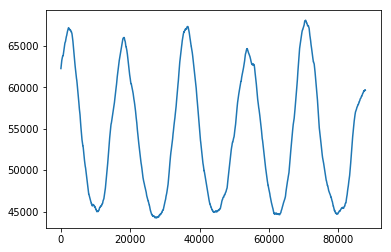

In [213]:
annual_trend = moving_average(ts.consumption_France_final.values, periods = 48*120)
plt.plot(annual_trend)

In [214]:
res_annual = ts.consumption_France_final.values - annual_trend

In [216]:
stats.describe(res_annual)

DescribeResult(nobs=87830, minmax=(-21901.087152777778, 27716.487271895836), mean=244.73170508581234, variance=55307715.47167542, skewness=0.2084339388620491, kurtosis=-0.2394383664388111)

# Modèle classique

In [217]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,35,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,70,35,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = dataset['train']['x'][0].shape[1]

In [219]:
# paramètres du modèle variationnel choisi

## pour l'erreur de reconstruction (entre L1 et L2)
is_L2_Loss=False

## pour le choix du prior univarié exponentiel entre 'Gaussian' et 'Laplace':
prior = 'Laplace'

## pour la régularisation de la fonction objectif : VAE classique --> beta = 1 et gamma = 0
Beta = K.variable(0.4, dtype='float32') 

InfoVAE = True #pour activer la régularisation supplémentaire InfoVAE
Gamma = K.variable(8., dtype='float32')

In [220]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

In [221]:
# création du modèle
name_model = 'vae'
log_dir_projector=path_main_folder+"/notebooks/logs/Generation/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Generation/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model

model_vae = CVAE.cvae_model.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1, InfoVAE=InfoVAE,
                                beta=Beta, gamma = Gamma,  is_L2_Loss=is_L2_Loss,
                                name=name_model, output=path_out)

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 5454        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0        

In [222]:
#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/Generation/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---

Instructions for updating:
Use tf.cast instead.


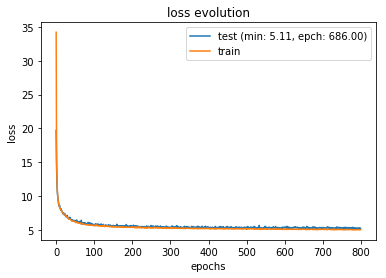

In [223]:
#apprentissage du modèle
 #use verbose=1 to see logs of training at every epoch
runTraining = False
if runTraining:
    model_vae.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.2)

## Evaluaer le modèle

In [224]:
#charger le modèle déjà entrainé si besoin
load_model=1-runTraining
if load_model:
    model_vae.load_model(os.path.join(path_out, name_model, 'models'))

In [225]:
# Récupération de la représentation latente via les distributions a posteriori des profils
input_encoder = dataset['train']['x']
x_train_encoded, variance = model_vae.encoder.predict(input_encoder)
variance_train= np.exp(variance)

input_encoder = dataset['test']['x']
x_test_encoded, variance = model_vae.encoder.predict(input_encoder)
variance_test= np.exp(variance)

Mutual Information Gap : 0.18


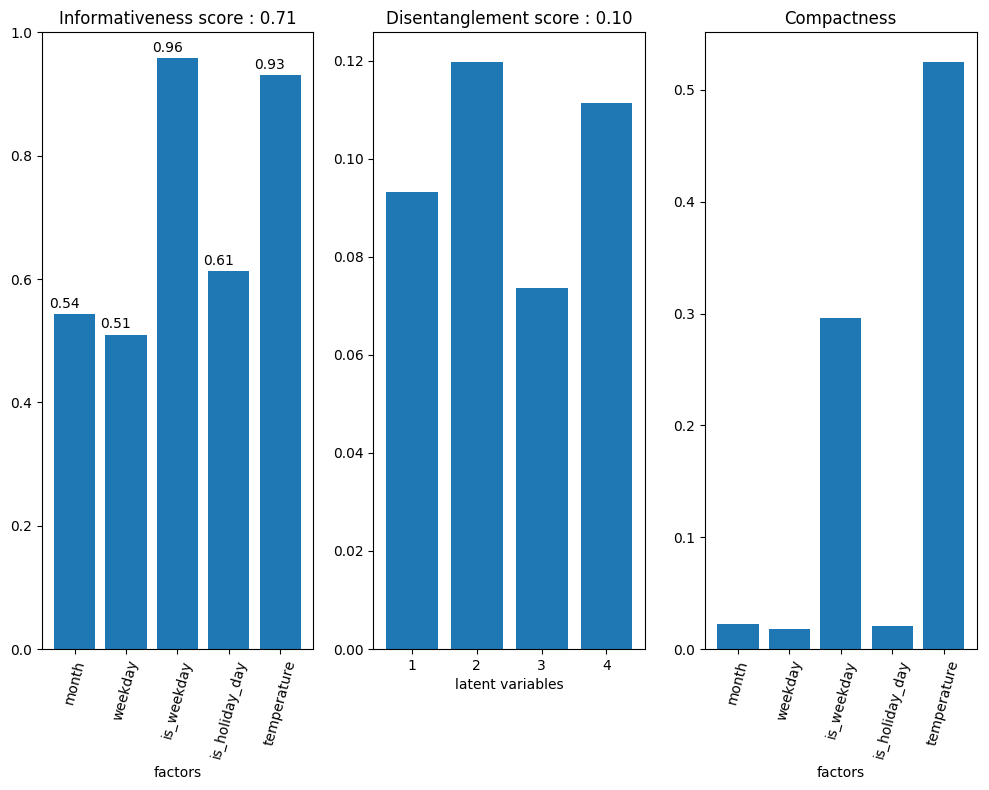

In [226]:
model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded, factorMatrix['train'], factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

Mutual Information Gap : 0.17


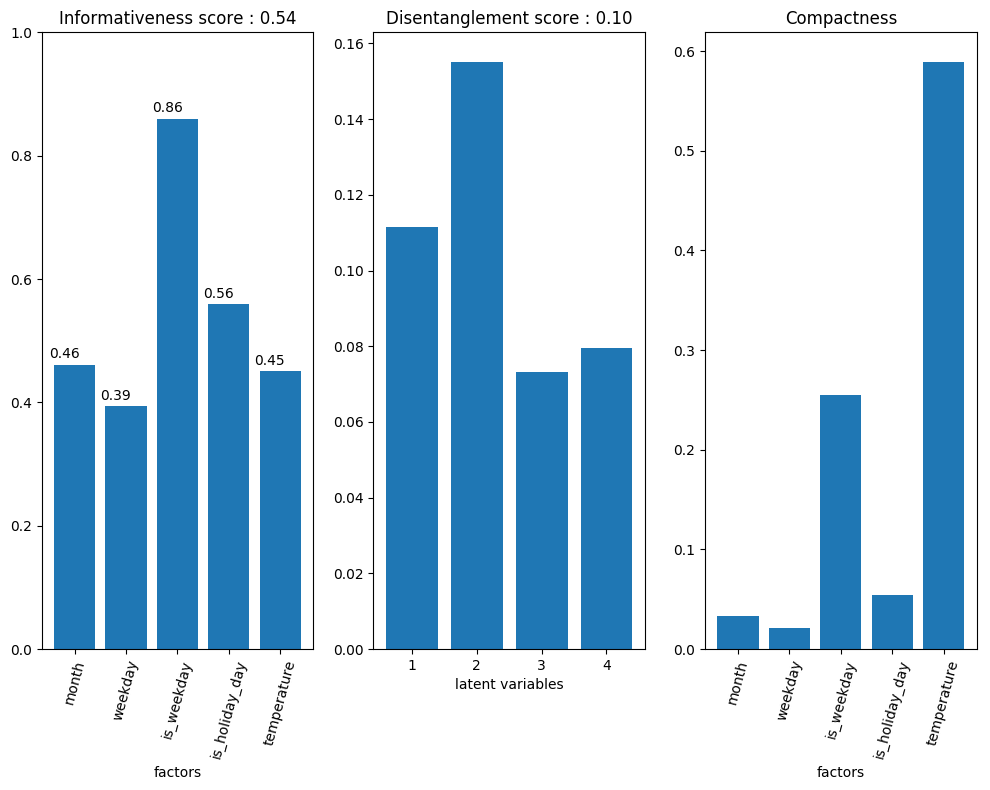

In [227]:
model_eval, importanceMatrix =evaluateLatentCode(x_test_encoded, factorMatrix['test'], factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

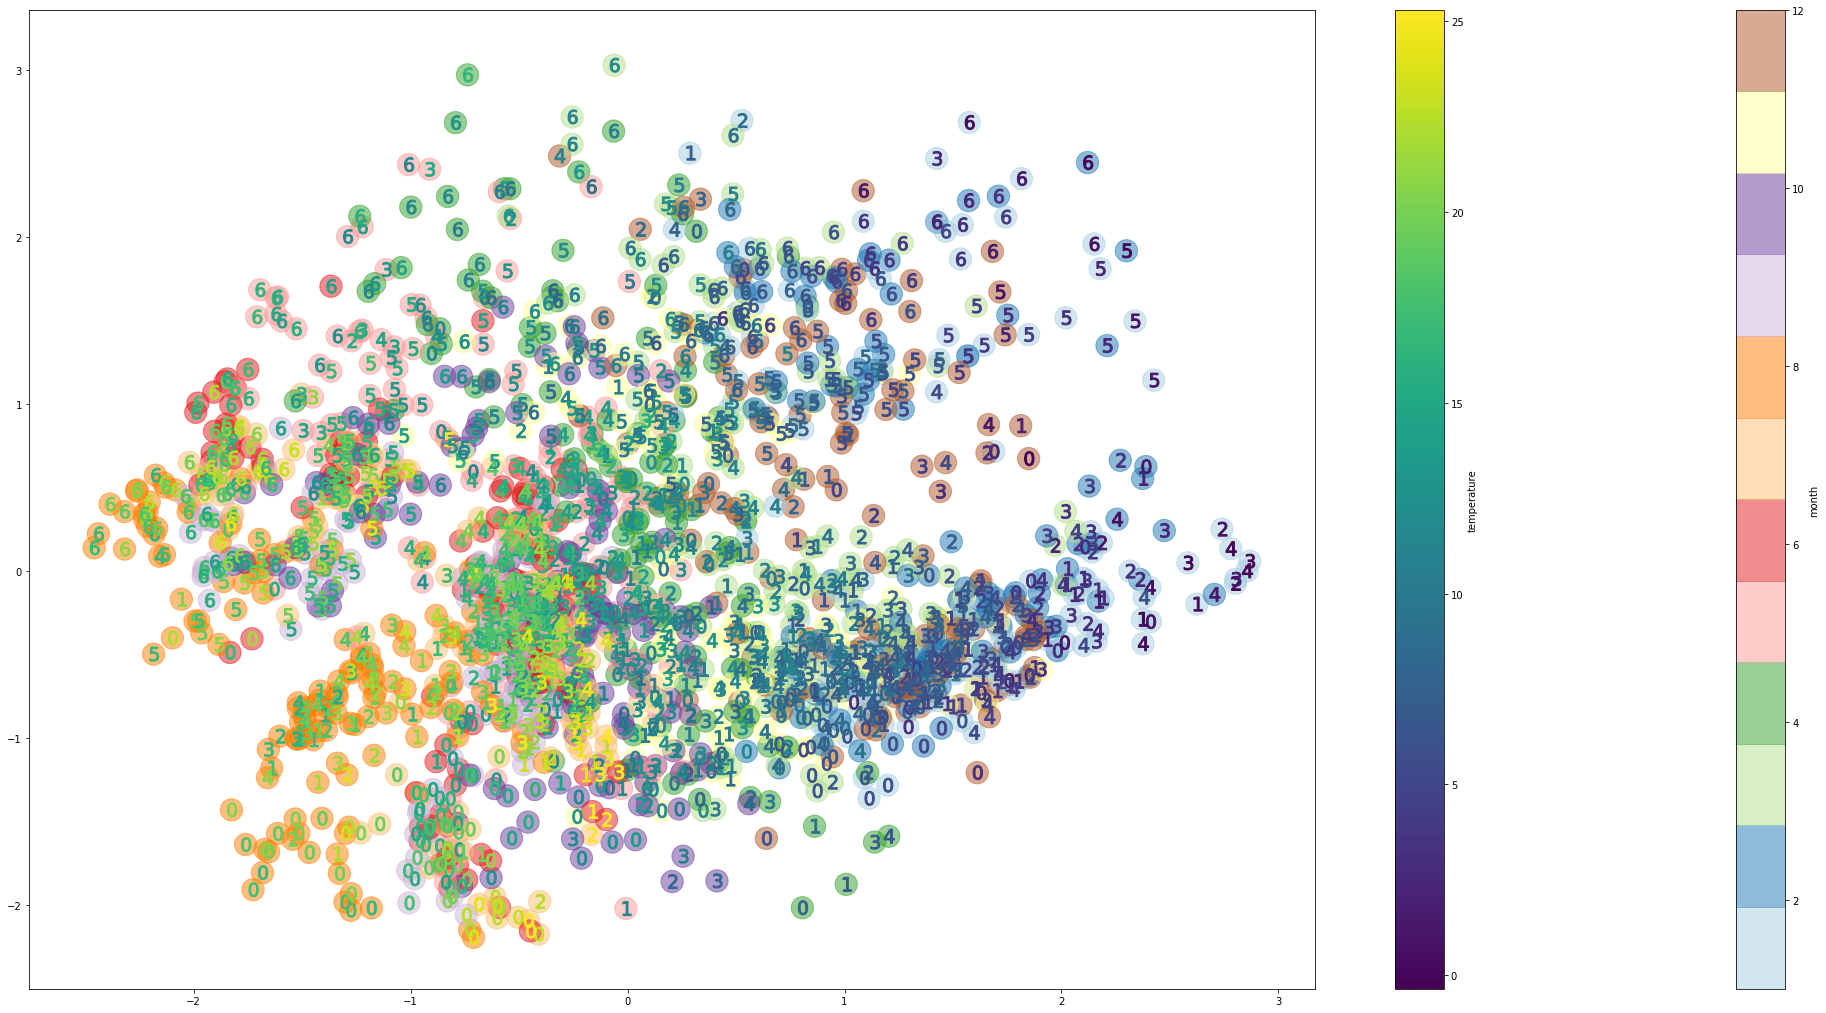

In [228]:
prez_2D(x_train_encoded, factorMatrix['train'])

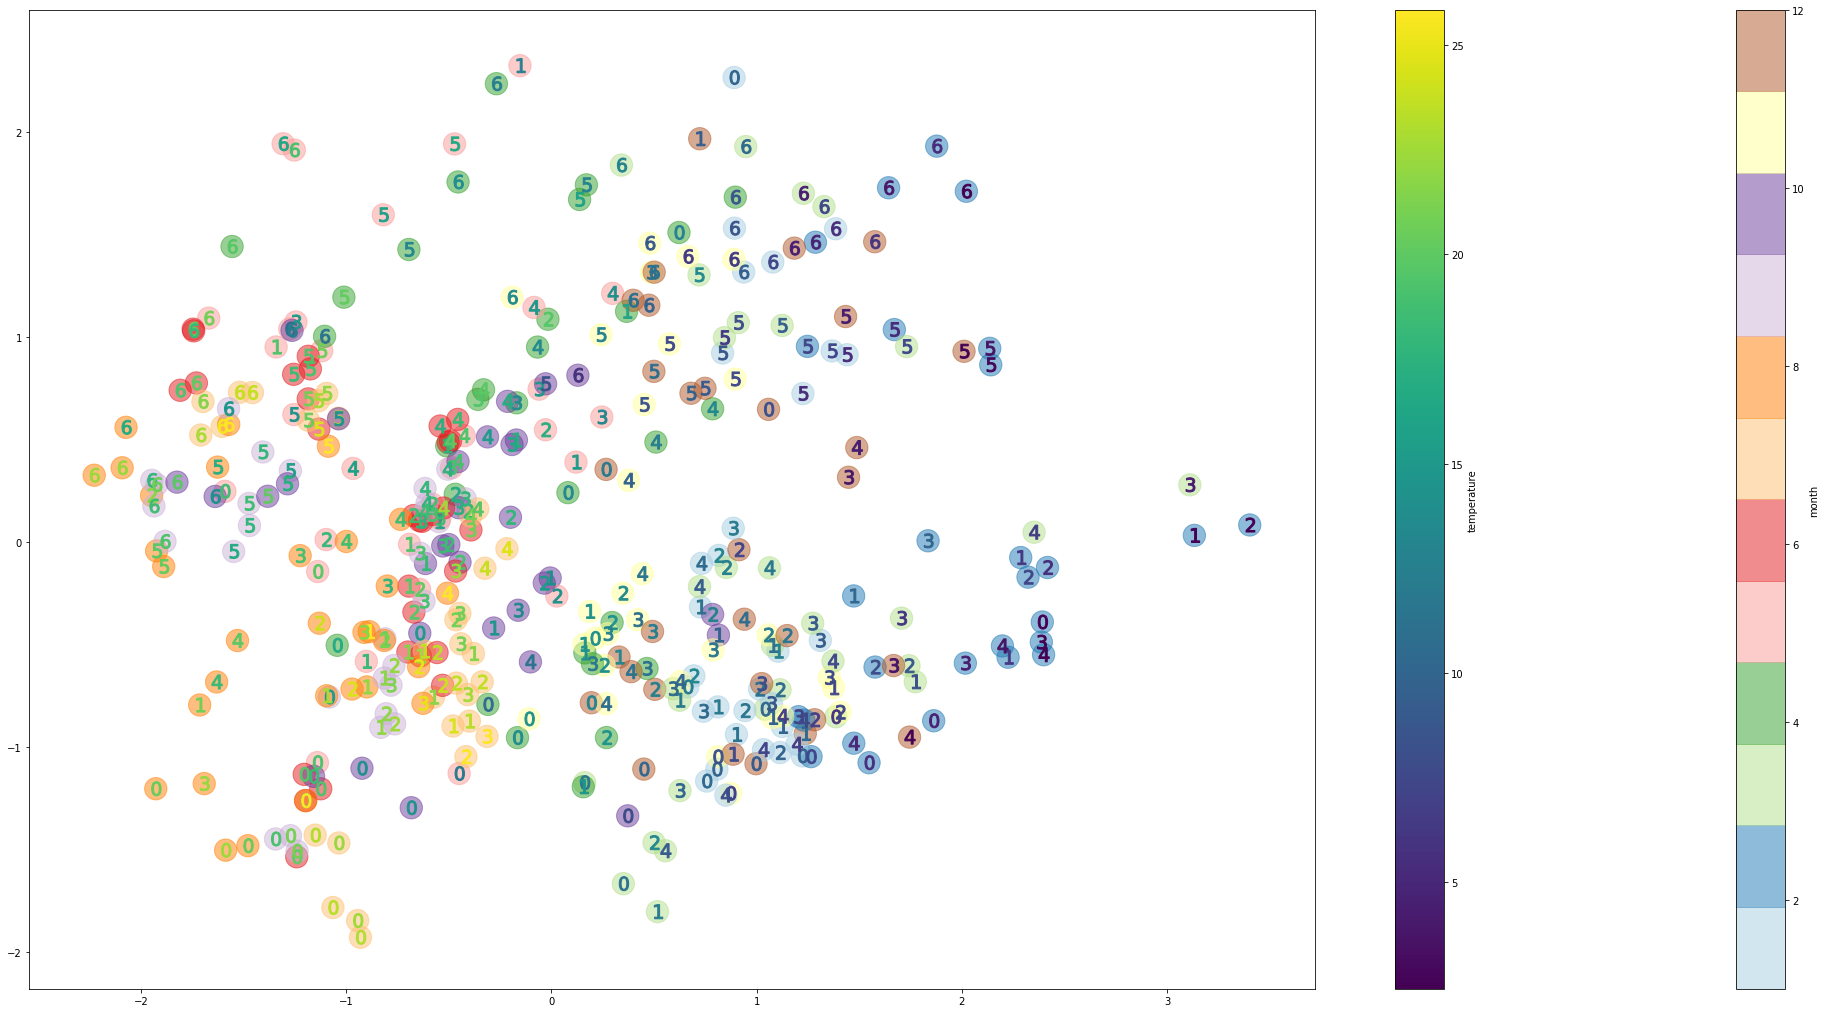

In [229]:
prez_2D(x_test_encoded, factorMatrix['test'])

In [230]:
#calculer l'erreur de reconstruction
x = dataset['test']['x'][0]
x_hat = model_vae.cvae.predict(input_encoder)[0]
mae_error = np.mean(np.abs((x - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((x - x_hat)**2, axis=1)) / 48

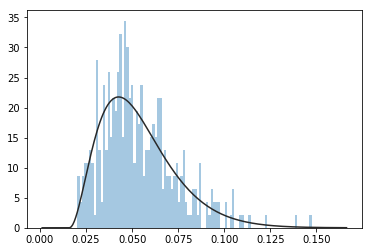

In [231]:
#faire un histogramme des écarts
import seaborn as sn
sn.distplot(mae_error, kde=False, fit=stats.beta, bins=100)

In [232]:
#vérification des dates avec la plus grande erreur de reconstruction
nDays=10

decreasingOrderIdx=np.argsort(-mae_error)
calendar_error=calendar_info['test'].loc[decreasingOrderIdx[0:nDays]]
calendar_error['error']=mae_error[decreasingOrderIdx[0:nDays]]
calendar_error

ds  month  weekday  is_weekday  is_holiday_day  year  \
299 2018-10-27     10        5           0               0  2018   
56  2018-02-26      2        0           1               0  2018   
357 2018-12-24     12        0           1               0  2018   
119 2018-04-30      4        0           1               0  2018   
348 2018-12-15     12        5           0               0  2018   
60  2018-03-02      3        4           1               0  2018   
358 2018-12-25     12        1           1               1  2018   
59  2018-03-01      3        3           1               0  2018   
360 2018-12-27     12        3           1               0  2018   
55  2018-02-25      2        6           0               0  2018   

     potential_bridge_holiday     error  
299                       0.0  0.147421  
56                        0.0  0.138818  
357                       1.0  0.123219  
119                       1.0  0.113435  
348                       0.0  0.110076  
60                        0.0  0.108409  
358                       0.0  0.105013  
59                        0.0  0.104847  
360                       0.0  0.104796  
55                        0.0  0.103151

In [233]:
from FeaturesScore.exploration import *
date = '2018-12-31'
KL_div = KL_distance(prior=prior)
search={'date':date}
search_idx = nearest_profiles(search,factorDesc, factorMatrix['test'], calendar_info['test'].ds, x_test_encoded, variance_test,metric=KL_div.pairwise, n_neighbors=10, radius=5)
calendar_info['test'].iloc[search_idx]

10 out of 10 neighbors whithin the radius limitation


ds  month  weekday  is_weekday  is_holiday_day  year  \
364 2018-12-31     12        0           1               0  2018   
303 2018-10-31     10        2           1               0  2018   
71  2018-03-13      3        1           1               0  2018   
333 2018-11-30     11        4           1               0  2018   
3   2018-01-04      1        3           1               0  2018   
4   2018-01-05      1        4           1               0  2018   
48  2018-02-18      2        6           0               0  2018   
86  2018-03-28      3        2           1               0  2018   
1   2018-01-02      1        1           1               0  2018   
72  2018-03-14      3        2           1               0  2018   

     potential_bridge_holiday  
364                       0.0  
303                       0.0  
71                        0.0  
333                       0.0  
3                         0.0  
4                         0.0  
48                        0.0  
86                        0.0  
1                         0.0  
72                        0.0

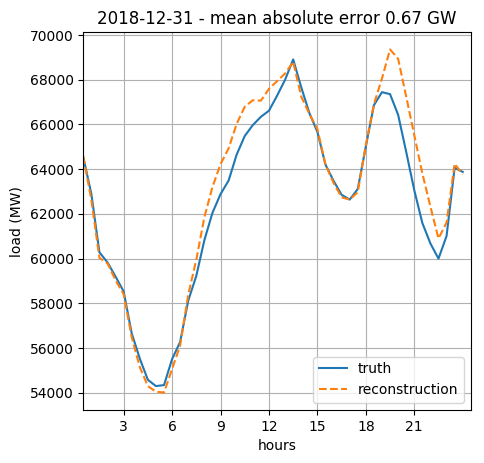

In [234]:
indice=364
display_loads(x[indice,:], x_hat[indice,:], str(dataset['test']['ds'].iloc[indice].date()), scaler=scaler)

In [36]:
calendar_info['test'].iloc[search_idx[0],1:5].to_dict()

{'month': 12, 'weekday': 0, 'is_weekday': 1, 'is_holiday_day': 0}

In [235]:
alt_search=calendar_info['test'].iloc[search_idx[0],1:4].to_dict()
alt_search.update({'temperature':factorMatrix['test'][search_idx[0],4]})
alt_search

{'month': 12, 'weekday': 0, 'is_weekday': 1, 'temperature': 5.948150460268646}

8 out of 8 neighbors whithin the radius limitation


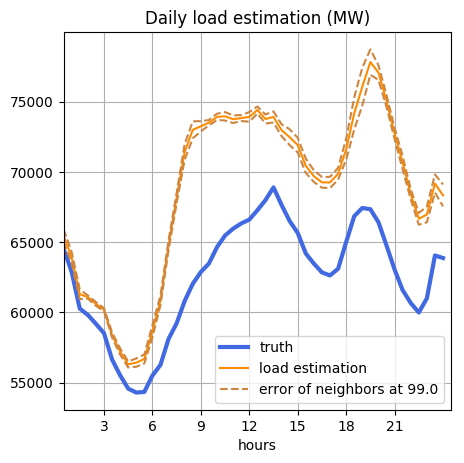

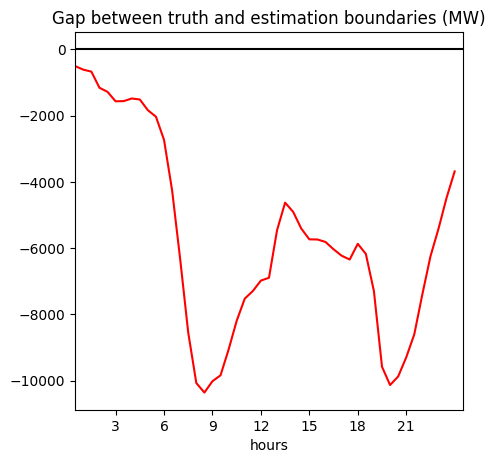

In [236]:
pred_search = generative_estimation(alt_search, model_vae, factorDesc, factorMatrix['train'], dataset['train'], x_train_encoded, variance_train, prior, metric=KL_div.pairwise, n_neighbors=8, trust=0.01, x_truth= dataset['test']['x'][0][indice,:], scaler=scaler, radius=3)

## Avec un autre modèle

In [237]:
import CVAE.cvae_model
import CVAE.cvae_model_mixture
import CVAE.cvae_model_cluster
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.cvae_model_mixture)
importlib.reload(CVAE.cvae_model_cluster)
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
name_model = 'cvae_modal'
log_dir_projector=path_main_folder+"/notebooks/logs/Generation/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Generation/"+name_model+"/model" 
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
Gamma = K.variable(8., dtype='float32')
Beta = K.variable(0.5, dtype='float32')
vae_modal = CVAE.cvae_model_mixture.CVAE_mixture(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1,
                                beta=Beta, is_L2_Loss=False,
                                prior_mu= np.linspace(-5, 5, num=8, endpoint=True),         
                                name=name_model, output=path_out)

L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 49086       x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0           encoder[1][3]

In [239]:
#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/Generation/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---



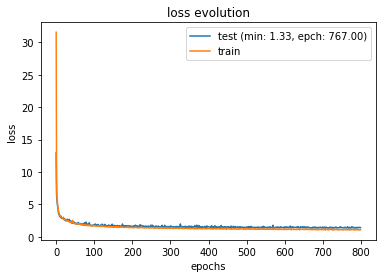

In [240]:
#apprentissage du modèle
 #use verbose=1 to see logs of training at every epoch
runTraining = True
if runTraining:
    vae_modal.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.2)

In [241]:
#charger le modèle déjà entrainé si besoin
load_model=1-runTraining
if load_model:
    vae_modal.load_model(os.path.join(path_out, name_model, 'models'))

## EValuation

In [242]:
# Récupération de la représentation latente via les distributions a posteriori des profils
input_encoder = dataset['train']['x']
x_train_encoded, mix_mu_train, mix_sigma_train, y_train = vae_modal.encoder.predict(input_encoder)
variance_train= np.sum(np.exp(mix_sigma_train)*(np.swapaxes(np.tile(y_train, (4,1,1)),0,1)**2), axis=2)

input_encoder = dataset['test']['x']
x_test_encoded, mix_mu_test, mix_sigma_test, y_test = vae_modal.encoder.predict(input_encoder)
variance_test= np.sum(np.exp(mix_sigma_test)*(np.swapaxes(np.tile(y_test, (4,1,1)),0,1)**2), axis=2)

In [243]:
variance_train.shape

(1830, 4)

Mutual Information Gap : 0.24


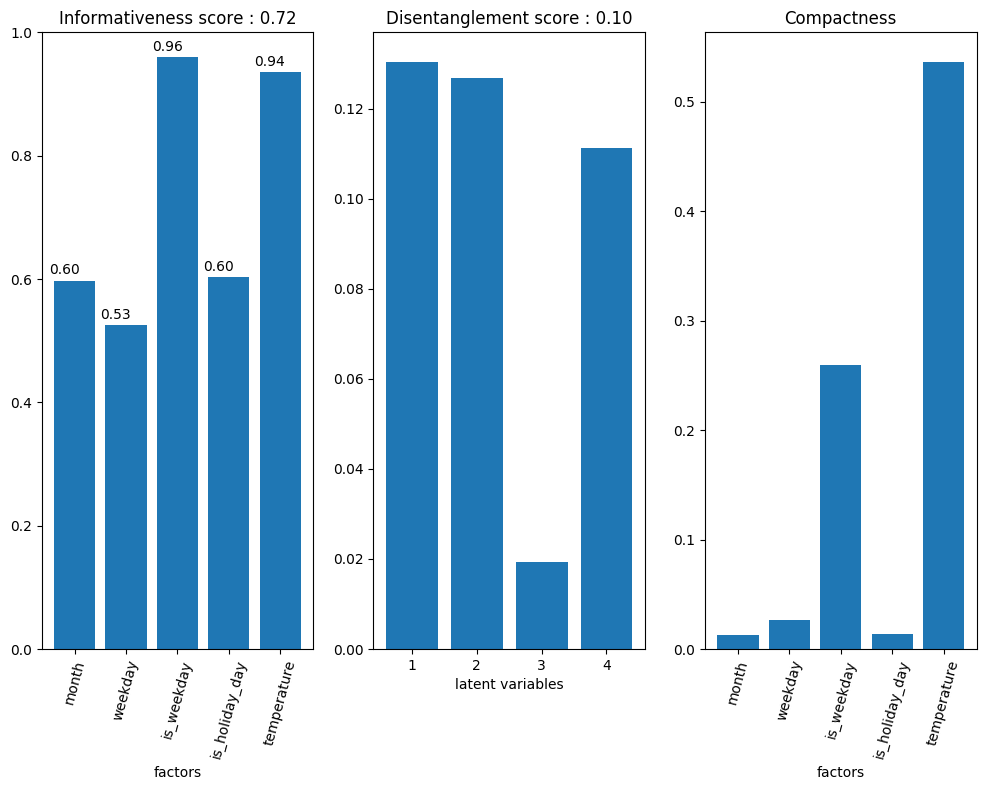

In [244]:
model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded, factorMatrix['train'], factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

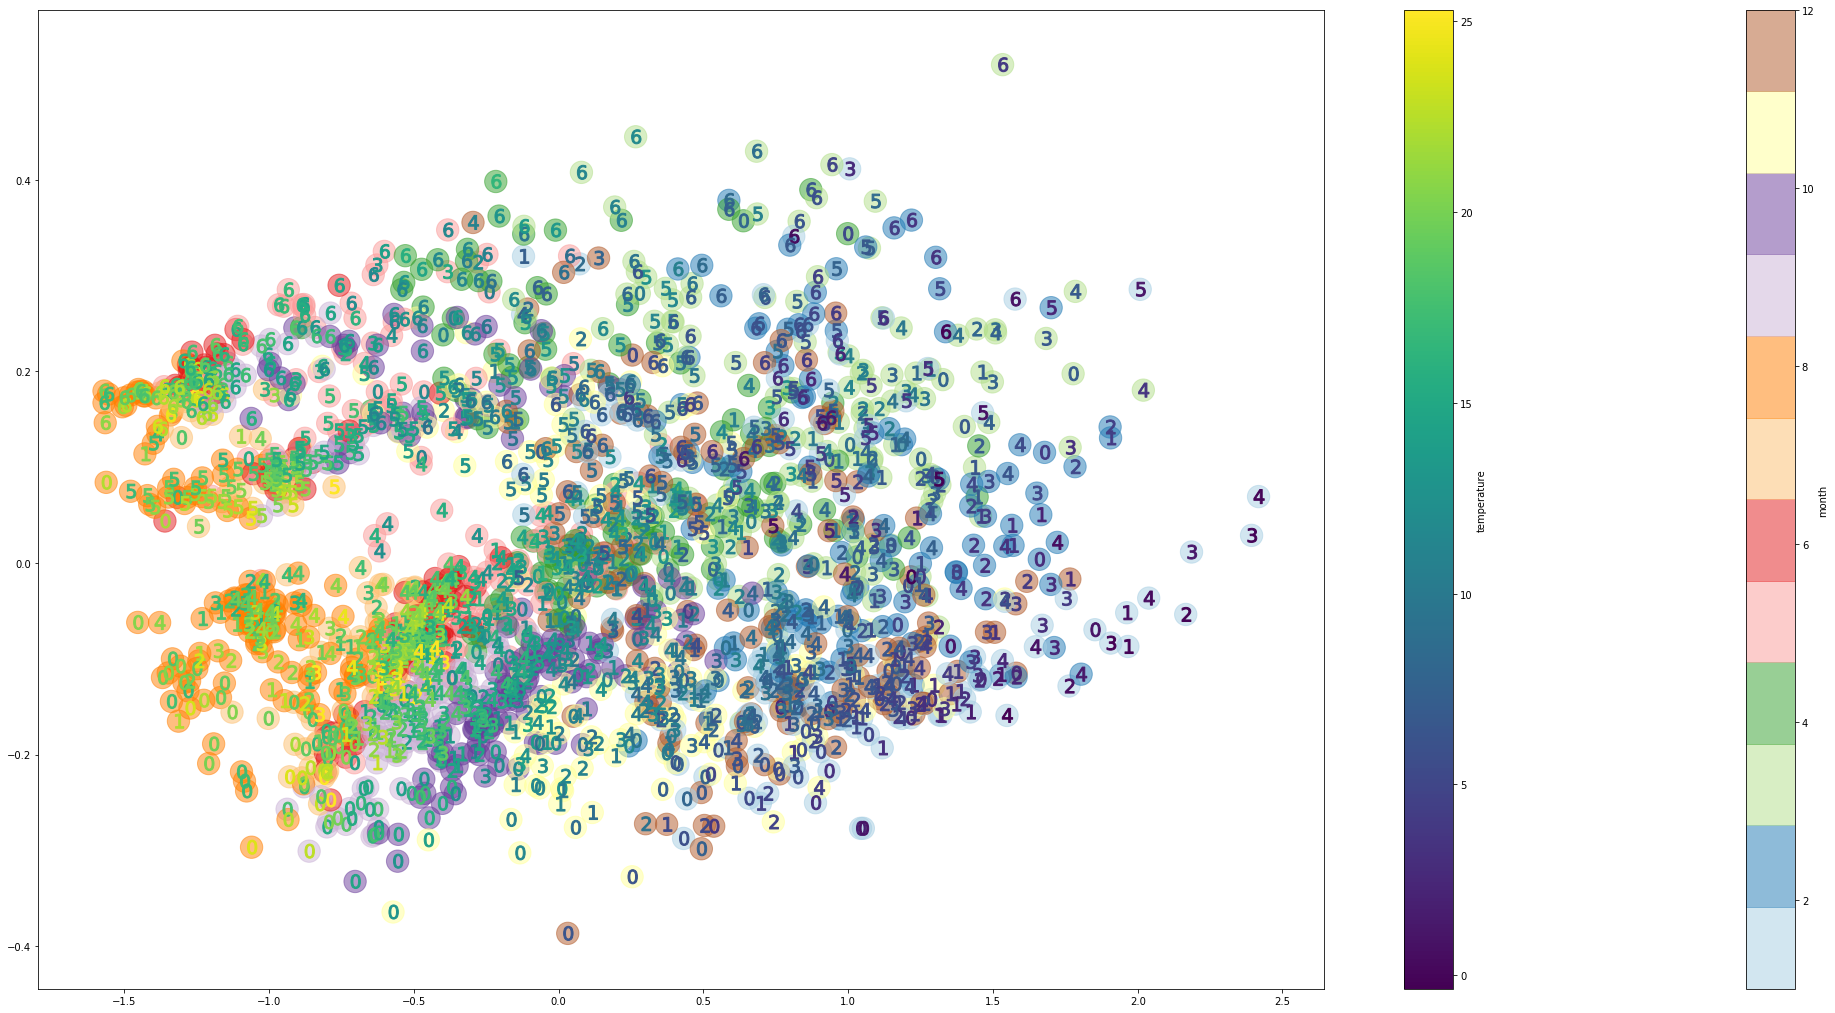

In [245]:
prez_2D(x_train_encoded, factorMatrix['train'])

Mutual Information Gap : 0.27


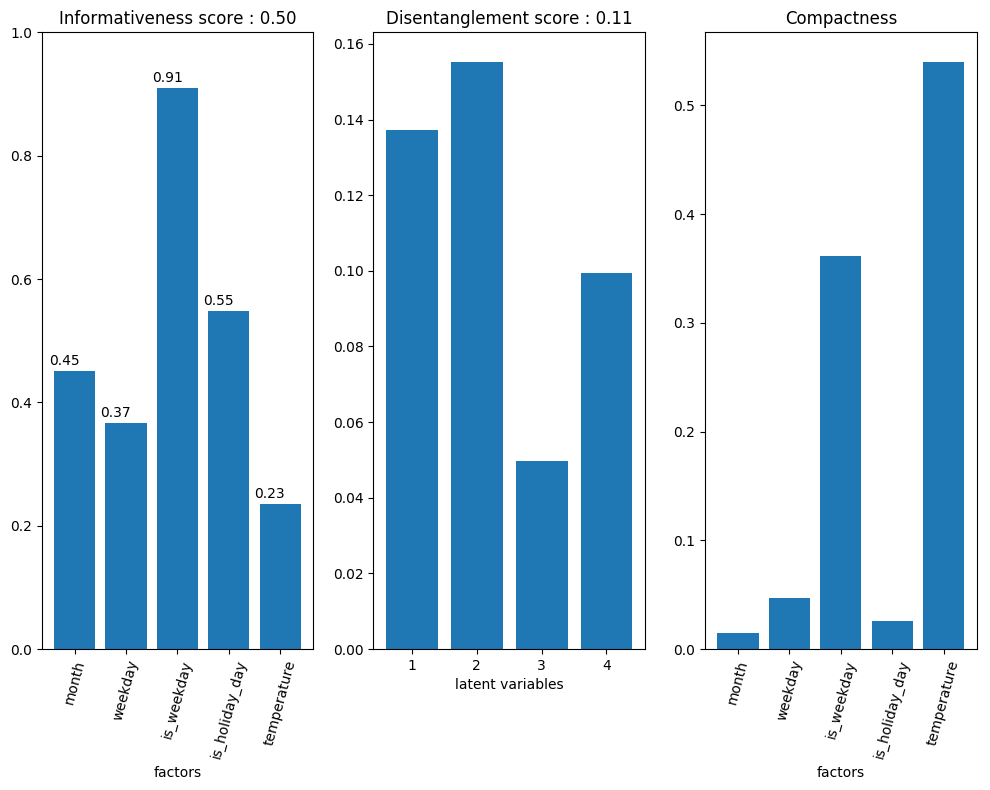

In [246]:
model_eval, importanceMatrix =evaluateLatentCode(x_test_encoded, factorMatrix['test'], factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

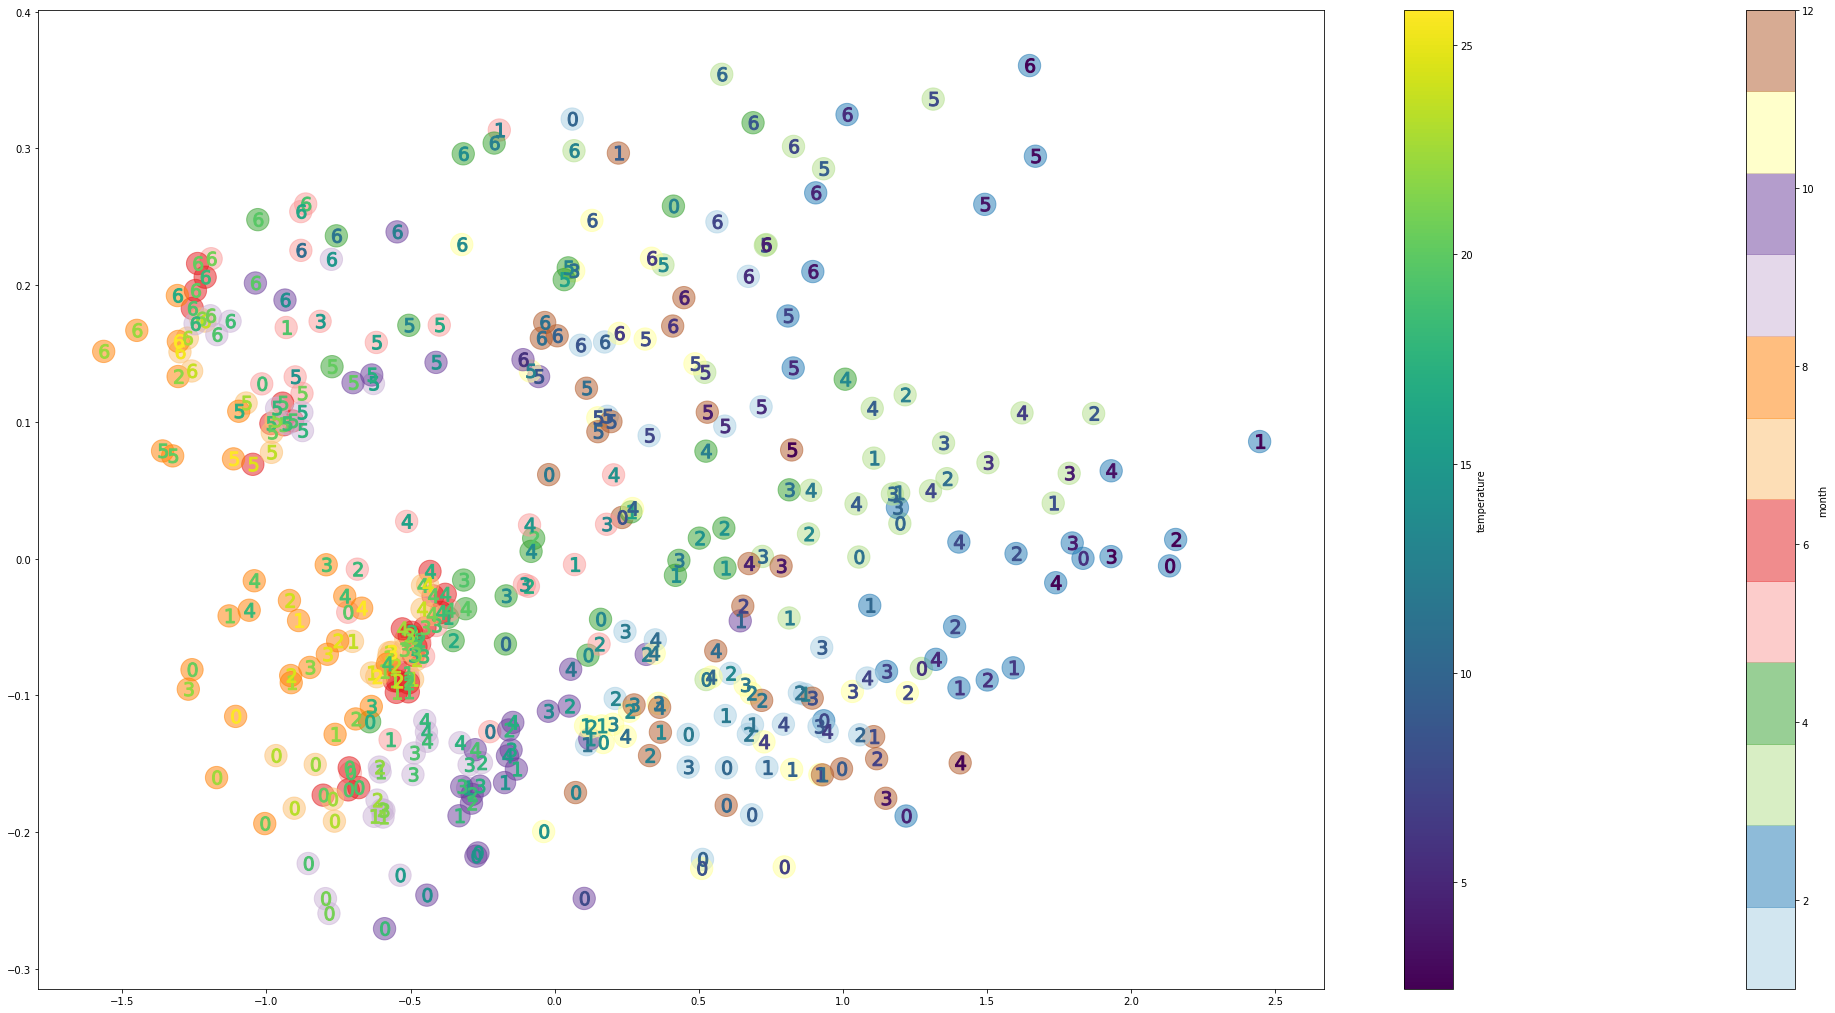

In [247]:
prez_2D(x_test_encoded, factorMatrix['test'])

In [50]:
model_eval['informativeness']

array([ 0.51631883,  0.37040505,  0.94763616,  0.49092827, -0.36004469])

In [51]:
#calculer l'erreur de reconstruction
x = dataset['test']['x'][0]
x_hat = vae_modal.cvae.predict(input_encoder)[0]
mae_error = np.mean(np.abs((x - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((x - x_hat)**2, axis=1)) / 48

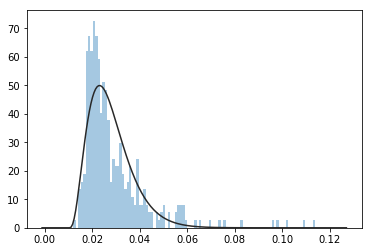

In [52]:
#faire un histogramme des écarts
import seaborn as sn
sn.distplot(mae_error, kde=False, fit=stats.beta, bins=100)

In [53]:
#vérification des dates avec la plus grande erreur de reconstruction
nDays=10

decreasingOrderIdx=np.argsort(-mae_error)
calendar_error=calendar_info['test'].loc[decreasingOrderIdx[0:nDays]]
calendar_error['error']=mae_error[decreasingOrderIdx[0:nDays]]
calendar_error

ds  month  weekday  is_weekday  is_holiday_day  year     error
61  2018-03-03      3        5           0               0  2018  0.113822
59  2018-03-01      3        3           1               0  2018  0.109373
60  2018-03-02      3        4           1               0  2018  0.101761
57  2018-02-27      2        1           1               0  2018  0.098439
358 2018-12-25     12        1           1               1  2018  0.095737
58  2018-02-28      2        2           1               0  2018  0.083083
56  2018-02-26      2        0           1               0  2018  0.075216
349 2018-12-16     12        6           0               0  2018  0.073499
19  2018-01-20      1        5           0               0  2018  0.069439
119 2018-04-30      4        0           1               0  2018  0.065662

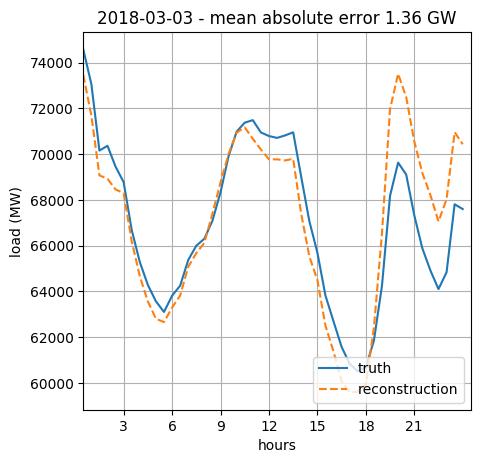

In [54]:
indice=61
display_loads(x[indice,:], x_hat[indice,:], str(dataset['test']['ds'].iloc[indice].date()), scaler=scaler)

In [55]:
date = dataset['test']['ds'].iloc[indice].date()
search={'date':date}
search_idx = nearest_profiles(search,factorDesc, factorMatrix['test'], calendar_info['test'].ds, x_test_encoded, n_neighbors=10, radius=5)
calendar_info['test'].iloc[search_idx]

10 out of 10 neighbors whithin the radius limitation


ds  month  weekday  is_weekday  is_holiday_day  year
61  2018-03-03      3        5           0               0  2018
54  2018-02-24      2        5           0               0  2018
40  2018-02-10      2        5           0               0  2018
62  2018-03-04      3        6           0               0  2018
33  2018-02-03      2        5           0               0  2018
48  2018-02-18      2        6           0               0  2018
55  2018-02-25      2        6           0               0  2018
349 2018-12-16     12        6           0               0  2018
348 2018-12-15     12        5           0               0  2018
13  2018-01-14      1        6           0               0  2018

In [83]:
alt_search=calendar_info['test'].iloc[search_idx[0],[3]].to_dict()
alt_search.update({'temperature':factorMatrix['test'][search_idx[0],4]})
alt_search.values

<function dict.values>

from xgboost import XGBRegressor

reg  = XGBRegressor(n_estimators = 100, learning_rate=0.05, max_depth=10)
features_train = factorMatrix['train'][:,[2,4]]
print(features_train.shape)
reg.fit(features_train, x_train_encoded)

pred_input_dec = [reg.predict(np.asarray([v for v in alt_search.values()]).reshape(1,-1))]+[np.zeros((1,1))]
pred = vae_modal.decoder.predict(pred_input_dec)[0]
display_loads(x[indice,:], pred, str(dataset['test']['ds'].iloc[indice].date()), scaler=scaler)

In [96]:
reg.predict(np.asarray([v for v in alt_search.values()]).reshape(1,-1))

array([-0.0505386], dtype=float32)

In [302]:
np.sum(np.isnan(dataset_all_cond['test']['x'][1]),axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

# Chercher avec le conditionnement

## Modèle InfoVAE

In [273]:
name_model = 'cvae'
log_dir_projector=path_main_folder+"/notebooks/logs/Generation/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Generation/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model

model_cvae = CVAE.cvae_model.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=dataset_all_cond['train']['x'][1].shape[1], InfoVAE=InfoVAE,
                                beta=Beta, gamma = Gamma,  is_L2_Loss=is_L2_Loss,
                                name=name_model, output=path_out)

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 69)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 13546       x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0        

In [274]:
#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/Generation/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---

Train on 1464 samples, validate on 366 samples
Epoch 1/800
1464/1464 [==============================] - 1s 711us/step - loss: 18204018658587.5625 - decoder_loss: 3271580.6204 - decoder_for_kl_loss: 36408029631782.7500 - decoder_info_loss: 0.2145 - val_loss: 725073589.7242 - val_decoder_loss: 45264.5387 - val_decoder_for_kl_loss: 1450056631.4854 - val_decoder_info_loss: 0.3698
Epoch 2/800
1464/1464 [==============================] - 0s 170us/step - loss: 84706045.4033 - decoder_loss: 14274.3020 - decoder_for_kl_loss: 169383538.1380 - decoder_info_loss: 0.2435 - val_loss: 4733985.3065 - val_decoder_loss: 5123.7038 - val_decoder_for_kl_loss: 9457716.4671 - val_decoder_info_loss: 0.4189
Epoch 3/800
1464/1464 [==============================] - 0s 168us/step - loss: 1540570.9428 - decoder_loss: 2505.4784 - decoder_for_kl_loss: 3076126.4847 - decoder_info_loss: 0.2787 - val_loss: 1175225.4745 - val_decoder_loss: 2770.3297 - val_decoder_for_kl_loss: 2344903.2553 - val

1464/1464 [==============================] - 0s 181us/step - loss: 11.9045 - decoder_loss: 9.7587 - decoder_for_kl_loss: 3.6445 - decoder_info_loss: 0.0404 - val_loss: 14.0883 - val_decoder_loss: 11.6302 - val_decoder_for_kl_loss: 4.0579 - val_decoder_info_loss: 0.0536
Epoch 30/800
1464/1464 [==============================] - 0s 194us/step - loss: 11.3395 - decoder_loss: 9.2282 - decoder_for_kl_loss: 3.6186 - decoder_info_loss: 0.0377 - val_loss: 13.7329 - val_decoder_loss: 11.1606 - val_decoder_for_kl_loss: 4.5357 - val_decoder_info_loss: 0.0381
Epoch 31/800
1464/1464 [==============================] - 0s 212us/step - loss: 11.5125 - decoder_loss: 9.3303 - decoder_for_kl_loss: 3.7217 - decoder_info_loss: 0.0402 - val_loss: 14.1063 - val_decoder_loss: 11.4756 - val_decoder_for_kl_loss: 4.5467 - val_decoder_info_loss: 0.0447
Epoch 32/800
1464/1464 [==============================] - 0s 189us/step - loss: 11.1541 - decoder_loss: 8.9832 - decoder_for_kl_loss: 3.7288 - decoder_info_loss: 0.

1464/1464 [==============================] - 0s 190us/step - loss: 8.7052 - decoder_loss: 6.5655 - decoder_for_kl_loss: 3.5474 - decoder_info_loss: 0.0458 - val_loss: 10.2159 - val_decoder_loss: 7.7802 - val_decoder_for_kl_loss: 4.0912 - val_decoder_info_loss: 0.0488
Epoch 59/800
1464/1464 [==============================] - 0s 168us/step - loss: 8.5176 - decoder_loss: 6.3613 - decoder_for_kl_loss: 3.5755 - decoder_info_loss: 0.0461 - val_loss: 9.8146 - val_decoder_loss: 7.2597 - val_decoder_for_kl_loss: 4.2064 - val_decoder_info_loss: 0.0565
Epoch 60/800
1464/1464 [==============================] - 0s 183us/step - loss: 8.4105 - decoder_loss: 6.2803 - decoder_for_kl_loss: 3.5231 - decoder_info_loss: 0.0461 - val_loss: 9.3911 - val_decoder_loss: 6.8698 - val_decoder_for_kl_loss: 4.2830 - val_decoder_info_loss: 0.0475
Epoch 61/800
1464/1464 [==============================] - 0s 173us/step - loss: 8.2572 - decoder_loss: 6.1054 - decoder_for_kl_loss: 3.5574 - decoder_info_loss: 0.0466 - va

1464/1464 [==============================] - 0s 188us/step - loss: 7.8032 - decoder_loss: 5.6520 - decoder_for_kl_loss: 3.5674 - decoder_info_loss: 0.0459 - val_loss: 8.8728 - val_decoder_loss: 6.4735 - val_decoder_for_kl_loss: 4.0259 - val_decoder_info_loss: 0.0483
Epoch 88/800
1464/1464 [==============================] - 0s 187us/step - loss: 7.4960 - decoder_loss: 5.3815 - decoder_for_kl_loss: 3.4889 - decoder_info_loss: 0.0463 - val_loss: 8.9011 - val_decoder_loss: 6.3982 - val_decoder_for_kl_loss: 4.1685 - val_decoder_info_loss: 0.0523
Epoch 89/800
1464/1464 [==============================] - 0s 197us/step - loss: 7.6293 - decoder_loss: 5.5425 - decoder_for_kl_loss: 3.4539 - decoder_info_loss: 0.0450 - val_loss: 8.5477 - val_decoder_loss: 6.1528 - val_decoder_for_kl_loss: 3.8476 - val_decoder_info_loss: 0.0589
Epoch 90/800
1464/1464 [==============================] - 0s 166us/step - loss: 7.5202 - decoder_loss: 5.4069 - decoder_for_kl_loss: 3.4380 - decoder_info_loss: 0.0493 - val

1464/1464 [==============================] - 0s 159us/step - loss: 7.5036 - decoder_loss: 5.4851 - decoder_for_kl_loss: 3.2929 - decoder_info_loss: 0.0465 - val_loss: 8.4111 - val_decoder_loss: 6.0286 - val_decoder_for_kl_loss: 3.8743 - val_decoder_info_loss: 0.0557
Epoch 117/800
1464/1464 [==============================] - 0s 152us/step - loss: 7.5040 - decoder_loss: 5.4478 - decoder_for_kl_loss: 3.3644 - decoder_info_loss: 0.0467 - val_loss: 8.8999 - val_decoder_loss: 6.6143 - val_decoder_for_kl_loss: 3.8022 - val_decoder_info_loss: 0.0481
Epoch 118/800
1464/1464 [==============================] - 0s 155us/step - loss: 7.5321 - decoder_loss: 5.4709 - decoder_for_kl_loss: 3.3469 - decoder_info_loss: 0.0485 - val_loss: 8.3908 - val_decoder_loss: 5.9827 - val_decoder_for_kl_loss: 3.8745 - val_decoder_info_loss: 0.0589
Epoch 119/800
1464/1464 [==============================] - 0s 156us/step - loss: 7.4462 - decoder_loss: 5.4166 - decoder_for_kl_loss: 3.3033 - decoder_info_loss: 0.0472 - 

1464/1464 [==============================] - 0s 153us/step - loss: 7.5017 - decoder_loss: 5.4916 - decoder_for_kl_loss: 3.2243 - decoder_info_loss: 0.0497 - val_loss: 8.5089 - val_decoder_loss: 6.3690 - val_decoder_for_kl_loss: 3.5169 - val_decoder_info_loss: 0.0477
Epoch 146/800
1464/1464 [==============================] - 0s 152us/step - loss: 7.2833 - decoder_loss: 5.2892 - decoder_for_kl_loss: 3.2266 - decoder_info_loss: 0.0476 - val_loss: 8.2663 - val_decoder_loss: 5.8954 - val_decoder_for_kl_loss: 3.6792 - val_decoder_info_loss: 0.0664
Epoch 147/800
1464/1464 [==============================] - 0s 154us/step - loss: 7.3739 - decoder_loss: 5.3769 - decoder_for_kl_loss: 3.2170 - decoder_info_loss: 0.0486 - val_loss: 7.9461 - val_decoder_loss: 5.6609 - val_decoder_for_kl_loss: 3.6097 - val_decoder_info_loss: 0.0600
Epoch 148/800
1464/1464 [==============================] - 0s 152us/step - loss: 7.1070 - decoder_loss: 5.1126 - decoder_for_kl_loss: 3.2375 - decoder_info_loss: 0.0470 - 

1464/1464 [==============================] - 0s 153us/step - loss: 7.2945 - decoder_loss: 5.3228 - decoder_for_kl_loss: 3.1330 - decoder_info_loss: 0.0507 - val_loss: 7.9079 - val_decoder_loss: 5.7030 - val_decoder_for_kl_loss: 3.5520 - val_decoder_info_loss: 0.0536
Epoch 175/800
1464/1464 [==============================] - 0s 152us/step - loss: 6.9754 - decoder_loss: 5.0007 - decoder_for_kl_loss: 3.1237 - decoder_info_loss: 0.0516 - val_loss: 7.5294 - val_decoder_loss: 5.3381 - val_decoder_for_kl_loss: 3.4924 - val_decoder_info_loss: 0.0556
Epoch 176/800
1464/1464 [==============================] - 0s 152us/step - loss: 7.2545 - decoder_loss: 5.2801 - decoder_for_kl_loss: 3.1650 - decoder_info_loss: 0.0490 - val_loss: 8.4138 - val_decoder_loss: 6.1907 - val_decoder_for_kl_loss: 3.4810 - val_decoder_info_loss: 0.0603
Epoch 177/800
1464/1464 [==============================] - 0s 155us/step - loss: 7.2448 - decoder_loss: 5.2917 - decoder_for_kl_loss: 3.1220 - decoder_info_loss: 0.0490 - 

1464/1464 [==============================] - 0s 154us/step - loss: 7.2191 - decoder_loss: 5.2783 - decoder_for_kl_loss: 3.0548 - decoder_info_loss: 0.0517 - val_loss: 7.4540 - val_decoder_loss: 5.3666 - val_decoder_for_kl_loss: 3.4116 - val_decoder_info_loss: 0.0477
Epoch 204/800
1464/1464 [==============================] - 0s 152us/step - loss: 7.1172 - decoder_loss: 5.1783 - decoder_for_kl_loss: 3.0597 - decoder_info_loss: 0.0511 - val_loss: 7.9074 - val_decoder_loss: 5.7498 - val_decoder_for_kl_loss: 3.4520 - val_decoder_info_loss: 0.0539
Epoch 205/800
1464/1464 [==============================] - 0s 155us/step - loss: 6.9560 - decoder_loss: 5.0017 - decoder_for_kl_loss: 3.0816 - decoder_info_loss: 0.0517 - val_loss: 7.9526 - val_decoder_loss: 5.7671 - val_decoder_for_kl_loss: 3.4778 - val_decoder_info_loss: 0.0558
Epoch 206/800
1464/1464 [==============================] - 0s 157us/step - loss: 6.9980 - decoder_loss: 5.0517 - decoder_for_kl_loss: 3.0613 - decoder_info_loss: 0.0520 - 

1464/1464 [==============================] - 0s 158us/step - loss: 7.2219 - decoder_loss: 5.3324 - decoder_for_kl_loss: 2.9325 - decoder_info_loss: 0.0529 - val_loss: 8.3694 - val_decoder_loss: 6.3081 - val_decoder_for_kl_loss: 3.2266 - val_decoder_info_loss: 0.0560
Epoch 233/800
1464/1464 [==============================] - 0s 156us/step - loss: 6.8778 - decoder_loss: 4.9668 - decoder_for_kl_loss: 2.9796 - decoder_info_loss: 0.0527 - val_loss: 7.3519 - val_decoder_loss: 5.2254 - val_decoder_for_kl_loss: 3.4021 - val_decoder_info_loss: 0.0532
Epoch 234/800
1464/1464 [==============================] - 0s 155us/step - loss: 6.8467 - decoder_loss: 4.9331 - decoder_for_kl_loss: 3.0032 - decoder_info_loss: 0.0515 - val_loss: 8.0775 - val_decoder_loss: 5.9542 - val_decoder_for_kl_loss: 3.4037 - val_decoder_info_loss: 0.0527
Epoch 235/800
1464/1464 [==============================] - 0s 150us/step - loss: 6.7435 - decoder_loss: 4.7978 - decoder_for_kl_loss: 3.0306 - decoder_info_loss: 0.0538 - 

1464/1464 [==============================] - 0s 152us/step - loss: 6.8558 - decoder_loss: 4.9701 - decoder_for_kl_loss: 2.9137 - decoder_info_loss: 0.0536 - val_loss: 7.2613 - val_decoder_loss: 5.1334 - val_decoder_for_kl_loss: 3.3238 - val_decoder_info_loss: 0.0582
Epoch 262/800
1464/1464 [==============================] - 0s 152us/step - loss: 6.6432 - decoder_loss: 4.7416 - decoder_for_kl_loss: 2.9302 - decoder_info_loss: 0.0546 - val_loss: 7.4537 - val_decoder_loss: 5.3939 - val_decoder_for_kl_loss: 3.3006 - val_decoder_info_loss: 0.0512
Epoch 263/800
1464/1464 [==============================] - 0s 156us/step - loss: 6.5551 - decoder_loss: 4.6824 - decoder_for_kl_loss: 2.9084 - decoder_info_loss: 0.0523 - val_loss: 7.0399 - val_decoder_loss: 4.8702 - val_decoder_for_kl_loss: 3.3255 - val_decoder_info_loss: 0.0634
Epoch 264/800
1464/1464 [==============================] - 0s 154us/step - loss: 6.5985 - decoder_loss: 4.6952 - decoder_for_kl_loss: 2.9330 - decoder_info_loss: 0.0546 - 

1464/1464 [==============================] - 0s 155us/step - loss: 6.5319 - decoder_loss: 4.6682 - decoder_for_kl_loss: 2.8571 - decoder_info_loss: 0.0544 - val_loss: 7.1076 - val_decoder_loss: 5.1035 - val_decoder_for_kl_loss: 3.1745 - val_decoder_info_loss: 0.0521
Epoch 291/800
1464/1464 [==============================] - 0s 154us/step - loss: 6.2960 - decoder_loss: 4.3944 - decoder_for_kl_loss: 2.9543 - decoder_info_loss: 0.0531 - val_loss: 7.5548 - val_decoder_loss: 5.4371 - val_decoder_for_kl_loss: 3.4464 - val_decoder_info_loss: 0.0493
Epoch 292/800
1464/1464 [==============================] - 0s 154us/step - loss: 6.4206 - decoder_loss: 4.5196 - decoder_for_kl_loss: 2.9261 - decoder_info_loss: 0.0547 - val_loss: 7.1304 - val_decoder_loss: 5.0551 - val_decoder_for_kl_loss: 3.1937 - val_decoder_info_loss: 0.0598
Epoch 293/800
1464/1464 [==============================] - 0s 154us/step - loss: 6.6534 - decoder_loss: 4.7932 - decoder_for_kl_loss: 2.8408 - decoder_info_loss: 0.0550 - 

1464/1464 [==============================] - 0s 156us/step - loss: 6.3057 - decoder_loss: 4.4188 - decoder_for_kl_loss: 2.8726 - decoder_info_loss: 0.0563 - val_loss: 7.1874 - val_decoder_loss: 5.0933 - val_decoder_for_kl_loss: 3.3086 - val_decoder_info_loss: 0.0550
Epoch 320/800
1464/1464 [==============================] - 0s 153us/step - loss: 6.1749 - decoder_loss: 4.2729 - decoder_for_kl_loss: 2.9293 - decoder_info_loss: 0.0547 - val_loss: 7.3118 - val_decoder_loss: 5.2056 - val_decoder_for_kl_loss: 3.3141 - val_decoder_info_loss: 0.0561
Epoch 321/800
1464/1464 [==============================] - 0s 153us/step - loss: 6.4515 - decoder_loss: 4.5750 - decoder_for_kl_loss: 2.9019 - decoder_info_loss: 0.0532 - val_loss: 7.0797 - val_decoder_loss: 4.9641 - val_decoder_for_kl_loss: 3.2706 - val_decoder_info_loss: 0.0600
Epoch 322/800
1464/1464 [==============================] - 0s 151us/step - loss: 6.1785 - decoder_loss: 4.2850 - decoder_for_kl_loss: 2.9033 - decoder_info_loss: 0.0552 - 

1464/1464 [==============================] - 0s 169us/step - loss: 6.0041 - decoder_loss: 4.1289 - decoder_for_kl_loss: 2.8780 - decoder_info_loss: 0.0545 - val_loss: 6.4914 - val_decoder_loss: 4.4020 - val_decoder_for_kl_loss: 3.0702 - val_decoder_info_loss: 0.0693
Epoch 349/800
1464/1464 [==============================] - 0s 163us/step - loss: 6.1306 - decoder_loss: 4.2881 - decoder_for_kl_loss: 2.8344 - decoder_info_loss: 0.0532 - val_loss: 6.3625 - val_decoder_loss: 4.3012 - val_decoder_for_kl_loss: 3.2031 - val_decoder_info_loss: 0.0575
Epoch 350/800
1464/1464 [==============================] - 0s 151us/step - loss: 6.0657 - decoder_loss: 4.2164 - decoder_for_kl_loss: 2.8373 - decoder_info_loss: 0.0538 - val_loss: 6.9252 - val_decoder_loss: 4.8428 - val_decoder_for_kl_loss: 3.1305 - val_decoder_info_loss: 0.0646
Epoch 351/800
1464/1464 [==============================] - 0s 154us/step - loss: 6.2111 - decoder_loss: 4.3268 - decoder_for_kl_loss: 2.8825 - decoder_info_loss: 0.0554 - 

1464/1464 [==============================] - 0s 154us/step - loss: 5.8388 - decoder_loss: 3.9336 - decoder_for_kl_loss: 2.9065 - decoder_info_loss: 0.0565 - val_loss: 6.3558 - val_decoder_loss: 4.3100 - val_decoder_for_kl_loss: 3.2396 - val_decoder_info_loss: 0.0533
Epoch 378/800
1464/1464 [==============================] - 0s 151us/step - loss: 5.9394 - decoder_loss: 4.0860 - decoder_for_kl_loss: 2.8474 - decoder_info_loss: 0.0537 - val_loss: 6.3252 - val_decoder_loss: 4.2751 - val_decoder_for_kl_loss: 3.4233 - val_decoder_info_loss: 0.0423
Epoch 379/800
1464/1464 [==============================] - 0s 152us/step - loss: 5.9812 - decoder_loss: 4.1166 - decoder_for_kl_loss: 2.8617 - decoder_info_loss: 0.0542 - val_loss: 6.7120 - val_decoder_loss: 4.7649 - val_decoder_for_kl_loss: 3.0304 - val_decoder_info_loss: 0.0540
Epoch 380/800
1464/1464 [==============================] - 0s 149us/step - loss: 5.9608 - decoder_loss: 4.0639 - decoder_for_kl_loss: 2.9121 - decoder_info_loss: 0.0551 - 

1464/1464 [==============================] - 0s 156us/step - loss: 5.9100 - decoder_loss: 4.0519 - decoder_for_kl_loss: 2.8409 - decoder_info_loss: 0.0547 - val_loss: 6.1257 - val_decoder_loss: 4.0574 - val_decoder_for_kl_loss: 3.1484 - val_decoder_info_loss: 0.0618
Epoch 407/800
1464/1464 [==============================] - 0s 152us/step - loss: 5.8067 - decoder_loss: 3.9086 - decoder_for_kl_loss: 2.8762 - decoder_info_loss: 0.0575 - val_loss: 6.5802 - val_decoder_loss: 4.5297 - val_decoder_for_kl_loss: 3.2513 - val_decoder_info_loss: 0.0531
Epoch 408/800
1464/1464 [==============================] - 0s 154us/step - loss: 5.6155 - decoder_loss: 3.7442 - decoder_for_kl_loss: 2.8704 - decoder_info_loss: 0.0545 - val_loss: 6.3504 - val_decoder_loss: 4.2781 - val_decoder_for_kl_loss: 3.2016 - val_decoder_info_loss: 0.0589
Epoch 409/800
1464/1464 [==============================] - 0s 156us/step - loss: 5.7079 - decoder_loss: 3.8656 - decoder_for_kl_loss: 2.8737 - decoder_info_loss: 0.0507 - 

1464/1464 [==============================] - 0s 156us/step - loss: 5.5947 - decoder_loss: 3.7031 - decoder_for_kl_loss: 2.9000 - decoder_info_loss: 0.0552 - val_loss: 6.3988 - val_decoder_loss: 4.3667 - val_decoder_for_kl_loss: 3.1665 - val_decoder_info_loss: 0.0561
Epoch 436/800
1464/1464 [==============================] - 0s 155us/step - loss: 5.7373 - decoder_loss: 3.8710 - decoder_for_kl_loss: 2.8516 - decoder_info_loss: 0.0551 - val_loss: 6.1602 - val_decoder_loss: 4.0821 - val_decoder_for_kl_loss: 3.2295 - val_decoder_info_loss: 0.0579
Epoch 437/800
1464/1464 [==============================] - 0s 159us/step - loss: 5.6032 - decoder_loss: 3.7322 - decoder_for_kl_loss: 2.8944 - decoder_info_loss: 0.0530 - val_loss: 6.5236 - val_decoder_loss: 4.4126 - val_decoder_for_kl_loss: 3.1788 - val_decoder_info_loss: 0.0652
Epoch 438/800
1464/1464 [==============================] - 0s 152us/step - loss: 5.5947 - decoder_loss: 3.7084 - decoder_for_kl_loss: 2.8758 - decoder_info_loss: 0.0560 - 

1464/1464 [==============================] - 0s 154us/step - loss: 5.4160 - decoder_loss: 3.5498 - decoder_for_kl_loss: 2.8813 - decoder_info_loss: 0.0532 - val_loss: 6.2326 - val_decoder_loss: 4.1644 - val_decoder_for_kl_loss: 3.3788 - val_decoder_info_loss: 0.0473
Epoch 465/800
1464/1464 [==============================] - 0s 154us/step - loss: 5.3840 - decoder_loss: 3.5411 - decoder_for_kl_loss: 2.8231 - decoder_info_loss: 0.0539 - val_loss: 6.5786 - val_decoder_loss: 4.4769 - val_decoder_for_kl_loss: 3.1416 - val_decoder_info_loss: 0.0664
Epoch 466/800
1464/1464 [==============================] - 0s 154us/step - loss: 5.7301 - decoder_loss: 3.8757 - decoder_for_kl_loss: 2.8481 - decoder_info_loss: 0.0538 - val_loss: 6.4904 - val_decoder_loss: 4.4051 - val_decoder_for_kl_loss: 3.0927 - val_decoder_info_loss: 0.0674
Epoch 467/800
1464/1464 [==============================] - 0s 155us/step - loss: 5.7227 - decoder_loss: 3.9061 - decoder_for_kl_loss: 2.7765 - decoder_info_loss: 0.0535 - 

1464/1464 [==============================] - 0s 156us/step - loss: 5.8502 - decoder_loss: 3.9852 - decoder_for_kl_loss: 2.8543 - decoder_info_loss: 0.0547 - val_loss: 5.9664 - val_decoder_loss: 3.9074 - val_decoder_for_kl_loss: 3.3305 - val_decoder_info_loss: 0.0492
Epoch 494/800
1464/1464 [==============================] - 0s 152us/step - loss: 5.6418 - decoder_loss: 3.7543 - decoder_for_kl_loss: 2.9011 - decoder_info_loss: 0.0546 - val_loss: 6.3388 - val_decoder_loss: 4.2270 - val_decoder_for_kl_loss: 3.2399 - val_decoder_info_loss: 0.0615
Epoch 495/800
1464/1464 [==============================] - 0s 152us/step - loss: 5.5825 - decoder_loss: 3.7203 - decoder_for_kl_loss: 2.8640 - decoder_info_loss: 0.0538 - val_loss: 6.0418 - val_decoder_loss: 3.9329 - val_decoder_for_kl_loss: 3.1083 - val_decoder_info_loss: 0.0694
Epoch 496/800
1464/1464 [==============================] - 0s 151us/step - loss: 5.3777 - decoder_loss: 3.5005 - decoder_for_kl_loss: 2.8942 - decoder_info_loss: 0.0538 - 

1464/1464 [==============================] - 0s 151us/step - loss: 5.5464 - decoder_loss: 3.7005 - decoder_for_kl_loss: 2.8498 - decoder_info_loss: 0.0526 - val_loss: 6.0560 - val_decoder_loss: 4.0295 - val_decoder_for_kl_loss: 3.3227 - val_decoder_info_loss: 0.0456
Epoch 523/800
1464/1464 [==============================] - 0s 153us/step - loss: 5.3305 - decoder_loss: 3.4568 - decoder_for_kl_loss: 2.8879 - decoder_info_loss: 0.0537 - val_loss: 6.5514 - val_decoder_loss: 4.4731 - val_decoder_for_kl_loss: 3.3427 - val_decoder_info_loss: 0.0509
Epoch 524/800
1464/1464 [==============================] - 0s 154us/step - loss: 5.3569 - decoder_loss: 3.4977 - decoder_for_kl_loss: 2.8488 - decoder_info_loss: 0.0543 - val_loss: 6.3789 - val_decoder_loss: 4.3664 - val_decoder_for_kl_loss: 3.2417 - val_decoder_info_loss: 0.0490
Epoch 525/800
1464/1464 [==============================] - 0s 154us/step - loss: 5.3223 - decoder_loss: 3.4552 - decoder_for_kl_loss: 2.8675 - decoder_info_loss: 0.0542 - 

1464/1464 [==============================] - 0s 158us/step - loss: 5.3480 - decoder_loss: 3.5039 - decoder_for_kl_loss: 2.8539 - decoder_info_loss: 0.0522 - val_loss: 6.2995 - val_decoder_loss: 4.2461 - val_decoder_for_kl_loss: 3.0306 - val_decoder_info_loss: 0.0673
Epoch 552/800
1464/1464 [==============================] - 0s 153us/step - loss: 5.3669 - decoder_loss: 3.5173 - decoder_for_kl_loss: 2.8283 - decoder_info_loss: 0.0544 - val_loss: 6.3333 - val_decoder_loss: 4.3228 - val_decoder_for_kl_loss: 3.1308 - val_decoder_info_loss: 0.0556
Epoch 553/800
1464/1464 [==============================] - 0s 153us/step - loss: 5.4749 - decoder_loss: 3.6089 - decoder_for_kl_loss: 2.8496 - decoder_info_loss: 0.0552 - val_loss: 5.8165 - val_decoder_loss: 3.7960 - val_decoder_for_kl_loss: 3.2382 - val_decoder_info_loss: 0.0502
Epoch 554/800
1464/1464 [==============================] - 0s 153us/step - loss: 5.3568 - decoder_loss: 3.5418 - decoder_for_kl_loss: 2.7881 - decoder_info_loss: 0.0526 - 

1464/1464 [==============================] - 0s 154us/step - loss: 5.2091 - decoder_loss: 3.3937 - decoder_for_kl_loss: 2.7663 - decoder_info_loss: 0.0540 - val_loss: 6.2462 - val_decoder_loss: 4.1827 - val_decoder_for_kl_loss: 3.3073 - val_decoder_info_loss: 0.0512
Epoch 581/800
1464/1464 [==============================] - 0s 152us/step - loss: 5.1737 - decoder_loss: 3.3490 - decoder_for_kl_loss: 2.8029 - decoder_info_loss: 0.0529 - val_loss: 5.7950 - val_decoder_loss: 3.6969 - val_decoder_for_kl_loss: 3.2950 - val_decoder_info_loss: 0.0563
Epoch 582/800
1464/1464 [==============================] - 0s 151us/step - loss: 5.1643 - decoder_loss: 3.2927 - decoder_for_kl_loss: 2.8753 - decoder_info_loss: 0.0542 - val_loss: 5.6597 - val_decoder_loss: 3.5890 - val_decoder_for_kl_loss: 3.2677 - val_decoder_info_loss: 0.0546
Epoch 583/800
1464/1464 [==============================] - 0s 150us/step - loss: 5.4707 - decoder_loss: 3.6149 - decoder_for_kl_loss: 2.8414 - decoder_info_loss: 0.0544 - 

1464/1464 [==============================] - 0s 155us/step - loss: 5.2713 - decoder_loss: 3.4584 - decoder_for_kl_loss: 2.7916 - decoder_info_loss: 0.0521 - val_loss: 6.2303 - val_decoder_loss: 4.2637 - val_decoder_for_kl_loss: 3.1091 - val_decoder_info_loss: 0.0515
Epoch 610/800
1464/1464 [==============================] - 0s 151us/step - loss: 5.1503 - decoder_loss: 3.2893 - decoder_for_kl_loss: 2.8607 - decoder_info_loss: 0.0538 - val_loss: 6.0266 - val_decoder_loss: 3.9577 - val_decoder_for_kl_loss: 3.0216 - val_decoder_info_loss: 0.0698
Epoch 611/800
1464/1464 [==============================] - 0s 151us/step - loss: 5.7379 - decoder_loss: 3.9201 - decoder_for_kl_loss: 2.7672 - decoder_info_loss: 0.0543 - val_loss: 7.0146 - val_decoder_loss: 4.9708 - val_decoder_for_kl_loss: 3.1793 - val_decoder_info_loss: 0.0568
Epoch 612/800
1464/1464 [==============================] - 0s 163us/step - loss: 5.4727 - decoder_loss: 3.6054 - decoder_for_kl_loss: 2.8653 - decoder_info_loss: 0.0543 - 

1464/1464 [==============================] - 0s 194us/step - loss: 5.2866 - decoder_loss: 3.4208 - decoder_for_kl_loss: 2.8592 - decoder_info_loss: 0.0545 - val_loss: 6.5816 - val_decoder_loss: 4.6037 - val_decoder_for_kl_loss: 3.0727 - val_decoder_info_loss: 0.0552
Epoch 639/800
1464/1464 [==============================] - 0s 183us/step - loss: 5.7821 - decoder_loss: 3.9303 - decoder_for_kl_loss: 2.8144 - decoder_info_loss: 0.0556 - val_loss: 7.0162 - val_decoder_loss: 5.0183 - val_decoder_for_kl_loss: 2.9926 - val_decoder_info_loss: 0.0627
Epoch 640/800
1464/1464 [==============================] - 0s 177us/step - loss: 5.3165 - decoder_loss: 3.4779 - decoder_for_kl_loss: 2.8246 - decoder_info_loss: 0.0533 - val_loss: 5.7533 - val_decoder_loss: 3.7100 - val_decoder_for_kl_loss: 3.1972 - val_decoder_info_loss: 0.0556
Epoch 641/800
1464/1464 [==============================] - 0s 186us/step - loss: 5.3816 - decoder_loss: 3.5624 - decoder_for_kl_loss: 2.7823 - decoder_info_loss: 0.0535 - 

1464/1464 [==============================] - 0s 190us/step - loss: 5.3467 - decoder_loss: 3.4787 - decoder_for_kl_loss: 2.8494 - decoder_info_loss: 0.0554 - val_loss: 5.6993 - val_decoder_loss: 3.5609 - val_decoder_for_kl_loss: 3.3602 - val_decoder_info_loss: 0.0573
Epoch 668/800
1464/1464 [==============================] - 0s 187us/step - loss: 5.1601 - decoder_loss: 3.3197 - decoder_for_kl_loss: 2.8282 - decoder_info_loss: 0.0533 - val_loss: 5.7598 - val_decoder_loss: 3.7560 - val_decoder_for_kl_loss: 3.1844 - val_decoder_info_loss: 0.0514
Epoch 669/800
1464/1464 [==============================] - 0s 187us/step - loss: 5.4361 - decoder_loss: 3.6056 - decoder_for_kl_loss: 2.8064 - decoder_info_loss: 0.0534 - val_loss: 5.6381 - val_decoder_loss: 3.6150 - val_decoder_for_kl_loss: 3.1503 - val_decoder_info_loss: 0.0560
Epoch 670/800
1464/1464 [==============================] - 0s 195us/step - loss: 5.1570 - decoder_loss: 3.3382 - decoder_for_kl_loss: 2.7882 - decoder_info_loss: 0.0531 - 

1464/1464 [==============================] - 0s 181us/step - loss: 5.0996 - decoder_loss: 3.2505 - decoder_for_kl_loss: 2.8461 - decoder_info_loss: 0.0533 - val_loss: 5.4995 - val_decoder_loss: 3.4383 - val_decoder_for_kl_loss: 3.3369 - val_decoder_info_loss: 0.0491
Epoch 697/800
1464/1464 [==============================] - 0s 165us/step - loss: 5.2845 - decoder_loss: 3.4645 - decoder_for_kl_loss: 2.7774 - decoder_info_loss: 0.0539 - val_loss: 5.8450 - val_decoder_loss: 3.7789 - val_decoder_for_kl_loss: 2.7976 - val_decoder_info_loss: 0.0834
Epoch 698/800
1464/1464 [==============================] - 0s 202us/step - loss: 5.3634 - decoder_loss: 3.5482 - decoder_for_kl_loss: 2.7663 - decoder_info_loss: 0.0540 - val_loss: 5.6161 - val_decoder_loss: 3.5818 - val_decoder_for_kl_loss: 3.2105 - val_decoder_info_loss: 0.0536
Epoch 699/800
1464/1464 [==============================] - 0s 205us/step - loss: 5.1024 - decoder_loss: 3.2620 - decoder_for_kl_loss: 2.8353 - decoder_info_loss: 0.0528 - 

1464/1464 [==============================] - 0s 152us/step - loss: 5.3510 - decoder_loss: 3.4934 - decoder_for_kl_loss: 2.8486 - decoder_info_loss: 0.0542 - val_loss: 5.6275 - val_decoder_loss: 3.5873 - val_decoder_for_kl_loss: 3.2012 - val_decoder_info_loss: 0.0549
Epoch 726/800
1464/1464 [==============================] - 0s 153us/step - loss: 5.2798 - decoder_loss: 3.4360 - decoder_for_kl_loss: 2.8217 - decoder_info_loss: 0.0541 - val_loss: 5.9856 - val_decoder_loss: 3.9003 - val_decoder_for_kl_loss: 3.2704 - val_decoder_info_loss: 0.0563
Epoch 727/800
1464/1464 [==============================] - 0s 156us/step - loss: 4.9956 - decoder_loss: 3.1196 - decoder_for_kl_loss: 2.8788 - decoder_info_loss: 0.0546 - val_loss: 5.4323 - val_decoder_loss: 3.2973 - val_decoder_for_kl_loss: 3.5279 - val_decoder_info_loss: 0.0464
Epoch 728/800
1464/1464 [==============================] - 0s 189us/step - loss: 5.1403 - decoder_loss: 3.3242 - decoder_for_kl_loss: 2.7976 - decoder_info_loss: 0.0522 - 

1464/1464 [==============================] - 0s 191us/step - loss: 5.0950 - decoder_loss: 3.2673 - decoder_for_kl_loss: 2.7901 - decoder_info_loss: 0.0541 - val_loss: 5.8401 - val_decoder_loss: 3.7984 - val_decoder_for_kl_loss: 3.0377 - val_decoder_info_loss: 0.0654
Epoch 755/800
1464/1464 [==============================] - 0s 189us/step - loss: 4.9538 - decoder_loss: 3.1258 - decoder_for_kl_loss: 2.7875 - decoder_info_loss: 0.0543 - val_loss: 5.8405 - val_decoder_loss: 3.6648 - val_decoder_for_kl_loss: 3.4938 - val_decoder_info_loss: 0.0536
Epoch 756/800
1464/1464 [==============================] - 0s 185us/step - loss: 5.3790 - decoder_loss: 3.5504 - decoder_for_kl_loss: 2.7599 - decoder_info_loss: 0.0561 - val_loss: 6.4820 - val_decoder_loss: 4.4709 - val_decoder_for_kl_loss: 3.0470 - val_decoder_info_loss: 0.0609
Epoch 757/800
1464/1464 [==============================] - 0s 163us/step - loss: 5.3412 - decoder_loss: 3.5148 - decoder_for_kl_loss: 2.7772 - decoder_info_loss: 0.0547 - 

1464/1464 [==============================] - 0s 186us/step - loss: 5.2501 - decoder_loss: 3.4112 - decoder_for_kl_loss: 2.8108 - decoder_info_loss: 0.0542 - val_loss: 5.8832 - val_decoder_loss: 3.8795 - val_decoder_for_kl_loss: 3.0232 - val_decoder_info_loss: 0.0615
Epoch 784/800
1464/1464 [==============================] - 0s 177us/step - loss: 4.8946 - decoder_loss: 3.0708 - decoder_for_kl_loss: 2.7887 - decoder_info_loss: 0.0537 - val_loss: 5.7026 - val_decoder_loss: 3.5589 - val_decoder_for_kl_loss: 3.4388 - val_decoder_info_loss: 0.0530
Epoch 785/800
1464/1464 [==============================] - 0s 155us/step - loss: 5.2344 - decoder_loss: 3.4338 - decoder_for_kl_loss: 2.7502 - decoder_info_loss: 0.0532 - val_loss: 5.7047 - val_decoder_loss: 3.6441 - val_decoder_for_kl_loss: 3.0868 - val_decoder_info_loss: 0.0647
Epoch 786/800
1464/1464 [==============================] - 0s 151us/step - loss: 4.9248 - decoder_loss: 3.1087 - decoder_for_kl_loss: 2.7574 - decoder_info_loss: 0.0547 - 

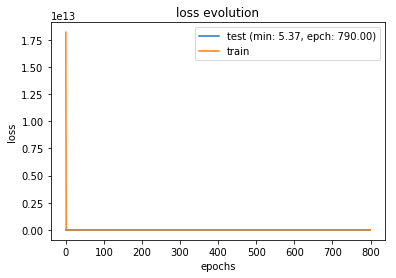

In [275]:
#apprentissage du modèle
 #use verbose=1 to see logs of training at every epoch
runTraining = False
if runTraining:
    model_cvae.main_train(dataset_all_cond, training_epochs=epochs, batch_size=batch_size, verbose=1,callbacks=[tensorboard],validation_split=0.2)

In [317]:
# Récupération de la représentation latente via les distributions a posteriori des profils
input_encoder = dataset_all_cond['train']['x']
x_train_encoded, variance = model_cvae.encoder.predict(input_encoder)
variance_train= np.exp(variance)

input_encoder = dataset_all_cond['test']['x']
x_test_encoded, variance = model_cvae.encoder.predict(input_encoder)
variance_test= np.exp(variance)

Mutual Information Gap : 0.04


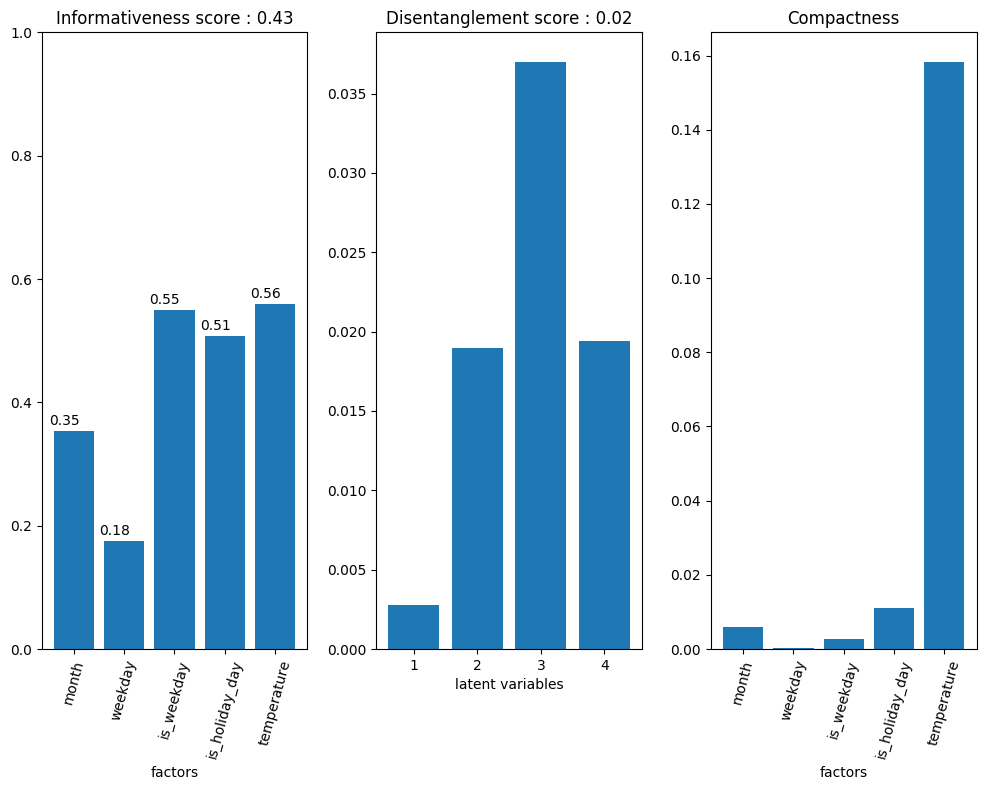

In [318]:
model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded, factorMatrix['train'], factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

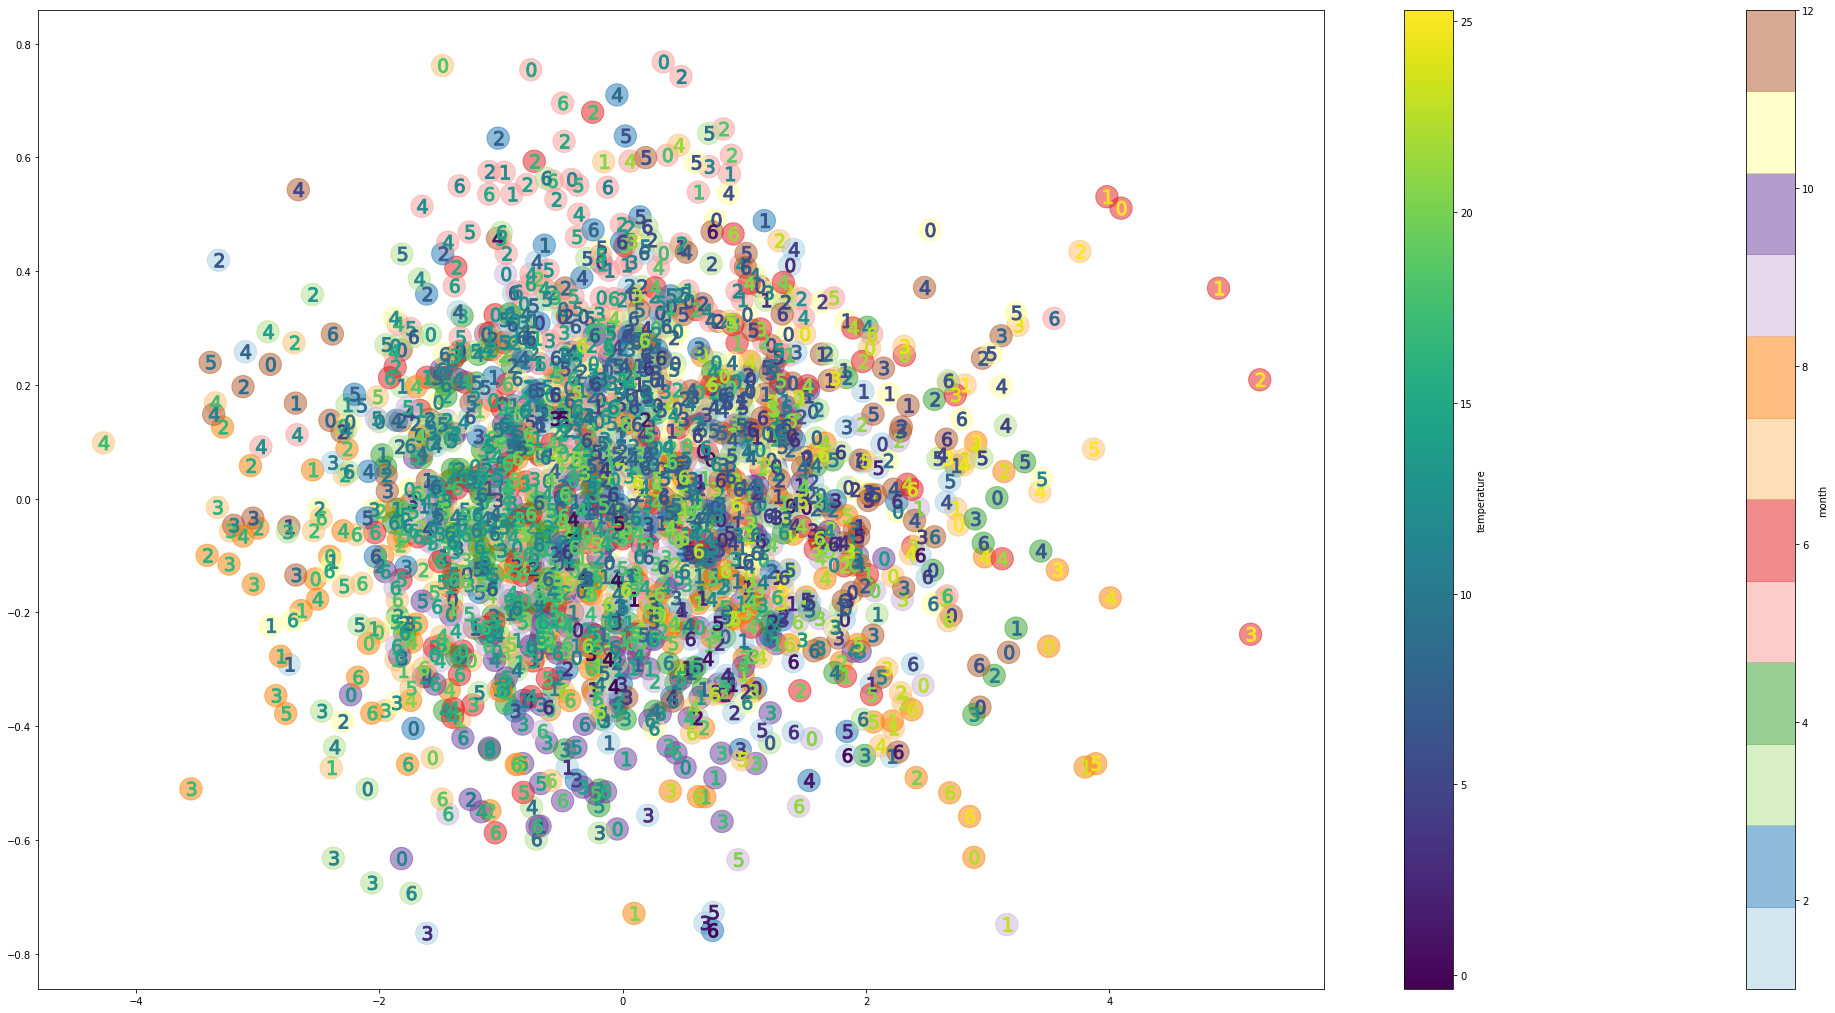

In [319]:
prez_2D(x_train_encoded,factorMatrix['train'])

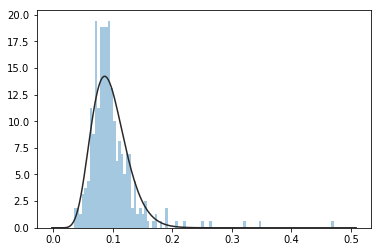

In [320]:
#calculer l'erreur de reconstruction
x = dataset_all_cond['test']['x'][0]
input_encoder = dataset_all_cond['test']['x']
x_hat = model_cvae.cvae.predict(input_encoder)[0]
mae_error = np.mean(np.abs((x - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((x - x_hat)**2, axis=1)) / 48

#faire un histogramme des écarts
sn.distplot(mae_error, kde=False, fit=stats.beta, bins=100)

In [321]:
#vérification des dates avec la plus grande erreur de reconstruction
nDays=10

decreasingOrderIdx=np.argsort(-mae_error)
calendar_error=calendar_info['test'].loc[decreasingOrderIdx[0:nDays]]
calendar_error['error']=mae_error[decreasingOrderIdx[0:nDays]]
calendar_error

ds  month  weekday  is_weekday  is_holiday_day  year  \
56  2018-02-26      2        0           1               0  2018   
59  2018-03-01      3        3           1               0  2018   
57  2018-02-27      2        1           1               0  2018   
0   2018-01-01      1        0           1               1  2018   
314 2018-11-11     11        6           0               1  2018   
58  2018-02-28      2        2           1               0  2018   
194 2018-07-14      7        5           0               1  2018   
348 2018-12-15     12        5           0               0  2018   
364 2018-12-31     12        0           1               0  2018   
347 2018-12-14     12        4           1               0  2018   

     potential_bridge_holiday     error  
56                        0.0  0.471614  
59                        0.0  0.345475  
57                        0.0  0.320055  
0                         0.0  0.263824  
314                       0.0  0.248774  
58                        0.0  0.220427  
194                       0.0  0.208995  
348                       0.0  0.188076  
364                       0.0  0.187947  
347                       0.0  0.187840

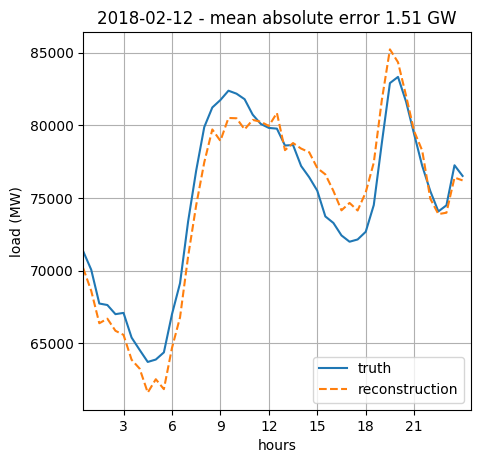

In [325]:
indice=42
display_loads(x[indice,:], x_hat[indice,:], str(dataset['test']['ds'].iloc[indice].date()), scaler=scaler)

In [326]:
date = dataset['test']['ds'].iloc[indice].date()
search={'date':date}
search_idx = nearest_profiles(search,factorDesc, factorMatrix['test'], calendar_info['test'].ds, x_test_encoded, n_neighbors=10, radius=5)
calendar_info['test'].iloc[search_idx]

10 out of 10 neighbors whithin the radius limitation


ds  month  weekday  is_weekday  is_holiday_day  year  \
42  2018-02-12      2        0           1               0  2018   
100 2018-04-11      4        2           1               0  2018   
85  2018-03-27      3        1           1               0  2018   
89  2018-03-31      3        5           0               0  2018   
33  2018-02-03      2        5           0               0  2018   
341 2018-12-08     12        5           0               0  2018   
246 2018-09-04      9        1           1               0  2018   
252 2018-09-10      9        0           1               0  2018   
253 2018-09-11      9        1           1               0  2018   
230 2018-08-19      8        6           0               0  2018   

     potential_bridge_holiday  
42                        0.0  
100                       0.0  
85                        0.0  
89                        0.0  
33                        0.0  
341                       0.0  
246                       0.0  
252                       0.0  
253                       0.0  
230                       0.0

In [327]:
alt_search=calendar_info['test'].iloc[search_idx[0],[3,4]].to_dict()
alt_search.update({'temperature':factorMatrix['test'][search_idx[0],4]})
alt_search

{'is_weekday': 1, 'is_holiday_day': 0, 'temperature': 2.9702356807655748}

In [330]:
search_idx2=nearest_profiles(alt_search,factorDesc, factorMatrix['test'], calendar_info['test'].ds, x_test_encoded, n_neighbors=10, radius=5)
calendar_info['test'].iloc[search_idx2]

10 out of 10 neighbors whithin the radius limitation


ds  month  weekday  is_weekday  is_holiday_day  year  \
16  2018-01-17      1        2           1               0  2018   
355 2018-12-22     12        5           0               0  2018   
28  2018-01-29      1        0           1               0  2018   
353 2018-12-20     12        3           1               0  2018   
103 2018-04-14      4        5           0               0  2018   
10  2018-01-11      1        3           1               0  2018   
319 2018-11-16     11        4           1               0  2018   
9   2018-01-10      1        2           1               0  2018   
25  2018-01-26      1        4           1               0  2018   
334 2018-12-01     12        5           0               0  2018   

     potential_bridge_holiday  
16                        0.0  
355                       0.0  
28                        0.0  
353                       0.0  
103                       0.0  
10                        0.0  
319                       0.0  
9                         0.0  
25                        0.0  
334                       0.0

In [331]:
def display_nearest_loads(list_x,date,scaler):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    for label,x in list_x.item():
        x = scaler.inverse_transform(x)
        plt.plot(x, label = label)
    plt.title(date)
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

# Time for guided-VAE ?

Based on the guided-dropout idea of B.Donnot: add condition embeddings in the latent space as perturbations.
* with true signal as input, simulate sensibilities of characterization for the profile
* with prevision day ahead as input (output still being the consommation curve), simulate the possibility of making it a prevision tool.

In [634]:
import CVAE.guided_vae_model

importlib.reload(CVAE.guided_vae_model)

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [548]:
input_dims = [dataset['train']['x'][0].shape[1]] + [7,1,12,48,1]

In [571]:
cond_dims = [[7,21,12],[1, 14], [12, 36, 12], [48,34,24,12], [1, 12]]


In [550]:
dataset_guided = {}
for key in ['train', 'test']:
    dataset_guided[key] = {}
    dataset_guided[key]['x']=[dataset_all_cond[key]['x'][0],dataset_all_cond[key]['x'][1][:,:7],
                              dataset_all_cond[key]['x'][1][:,7:8], dataset_all_cond[key]['x'][1][:,8:20],
                              dataset_all_cond[key]['x'][1][:,20:68],dataset_all_cond[key]['x'][1][:,68:]]
    dataset_guided[key]['y'] = dataset_all_cond[key]['y']
    dataset_guided[key]['ds'] = dataset_all_cond[key]['ds']

In [635]:
name_model = 'guided_vae'
log_dir_projector=path_main_folder+"/notebooks/logs/Generation/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Generation/"+name_model+"/model" 
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
Gamma = K.variable(8., dtype='float32')
Beta = K.variable(0.5, dtype='float32')
guided_vae = CVAE.guided_vae_model.Guided_VAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dims, cond_dims=cond_dims,InfoVAE=InfoVAE,
                                beta=Beta, gamma = Gamma, is_L2_Loss=False, prior='Laplace',         
                                name=name_model, output=path_out)

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
input_106 (InputLayer)          (None, 7)            0                                            
__________________________________________________________________________________________________
input_107 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_108 (InputLayer)          (None, 12)           0                                            
______________________________________________________________

In [636]:
#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/Generation/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---



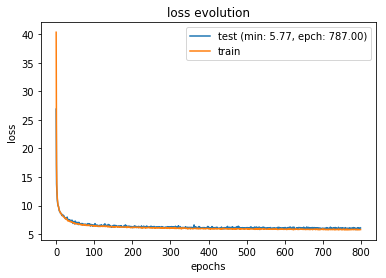

In [637]:
#apprentissage du modèle
 #use verbose=1 to see logs of training at every epoch
runTraining = True
if runTraining:
    guided_vae.main_train(dataset_guided, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.2)

In [638]:
#charger le modèle déjà entrainé si besoin
load_model=1-runTraining
if load_model:
    guided_vae.load_model(os.path.join(path_out, name_model, 'models'))

In [639]:
# Récupération de la représentation latente via les distributions a posteriori des profils
input_encoder = dataset_guided['train']['x']
x_train_encoded, log_sigma_train = guided_vae.encoder.predict(input_encoder)
variance_train= np.exp(log_sigma_train)

input_encoder = dataset_guided['test']['x']
x_test_encoded, log_sigma_test = guided_vae.encoder.predict(input_encoder)
variance_test= np.exp(log_sigma_test)

Mutual Information Gap : 0.17


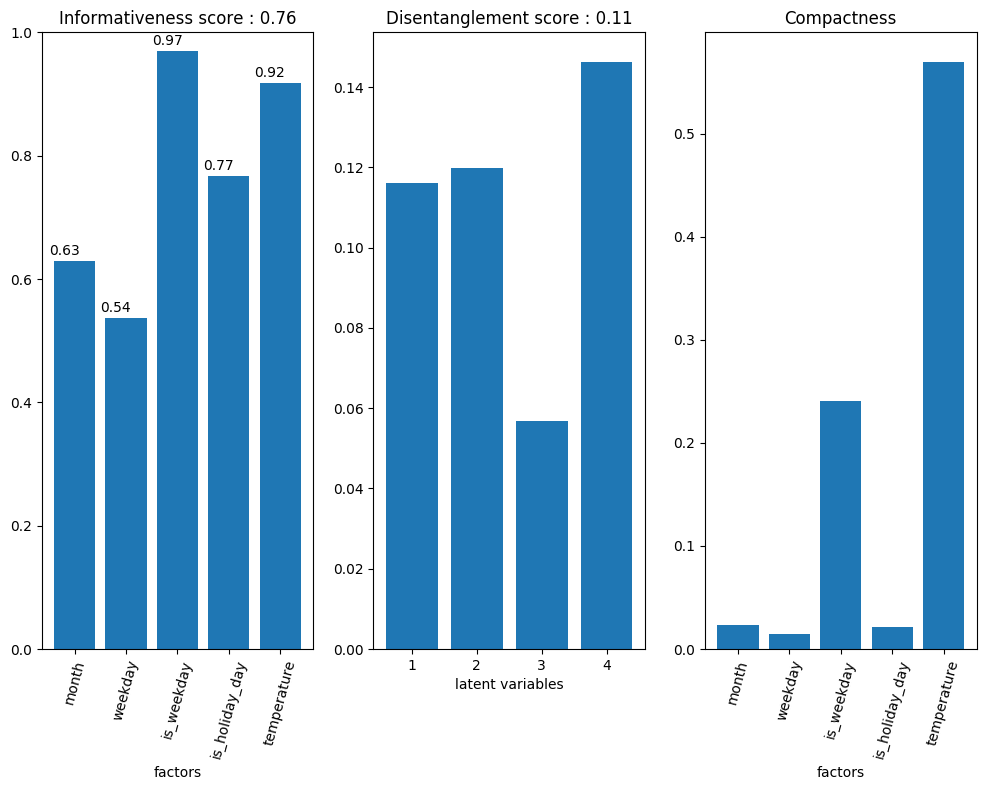

In [640]:
model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded, factorMatrix['train'], factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

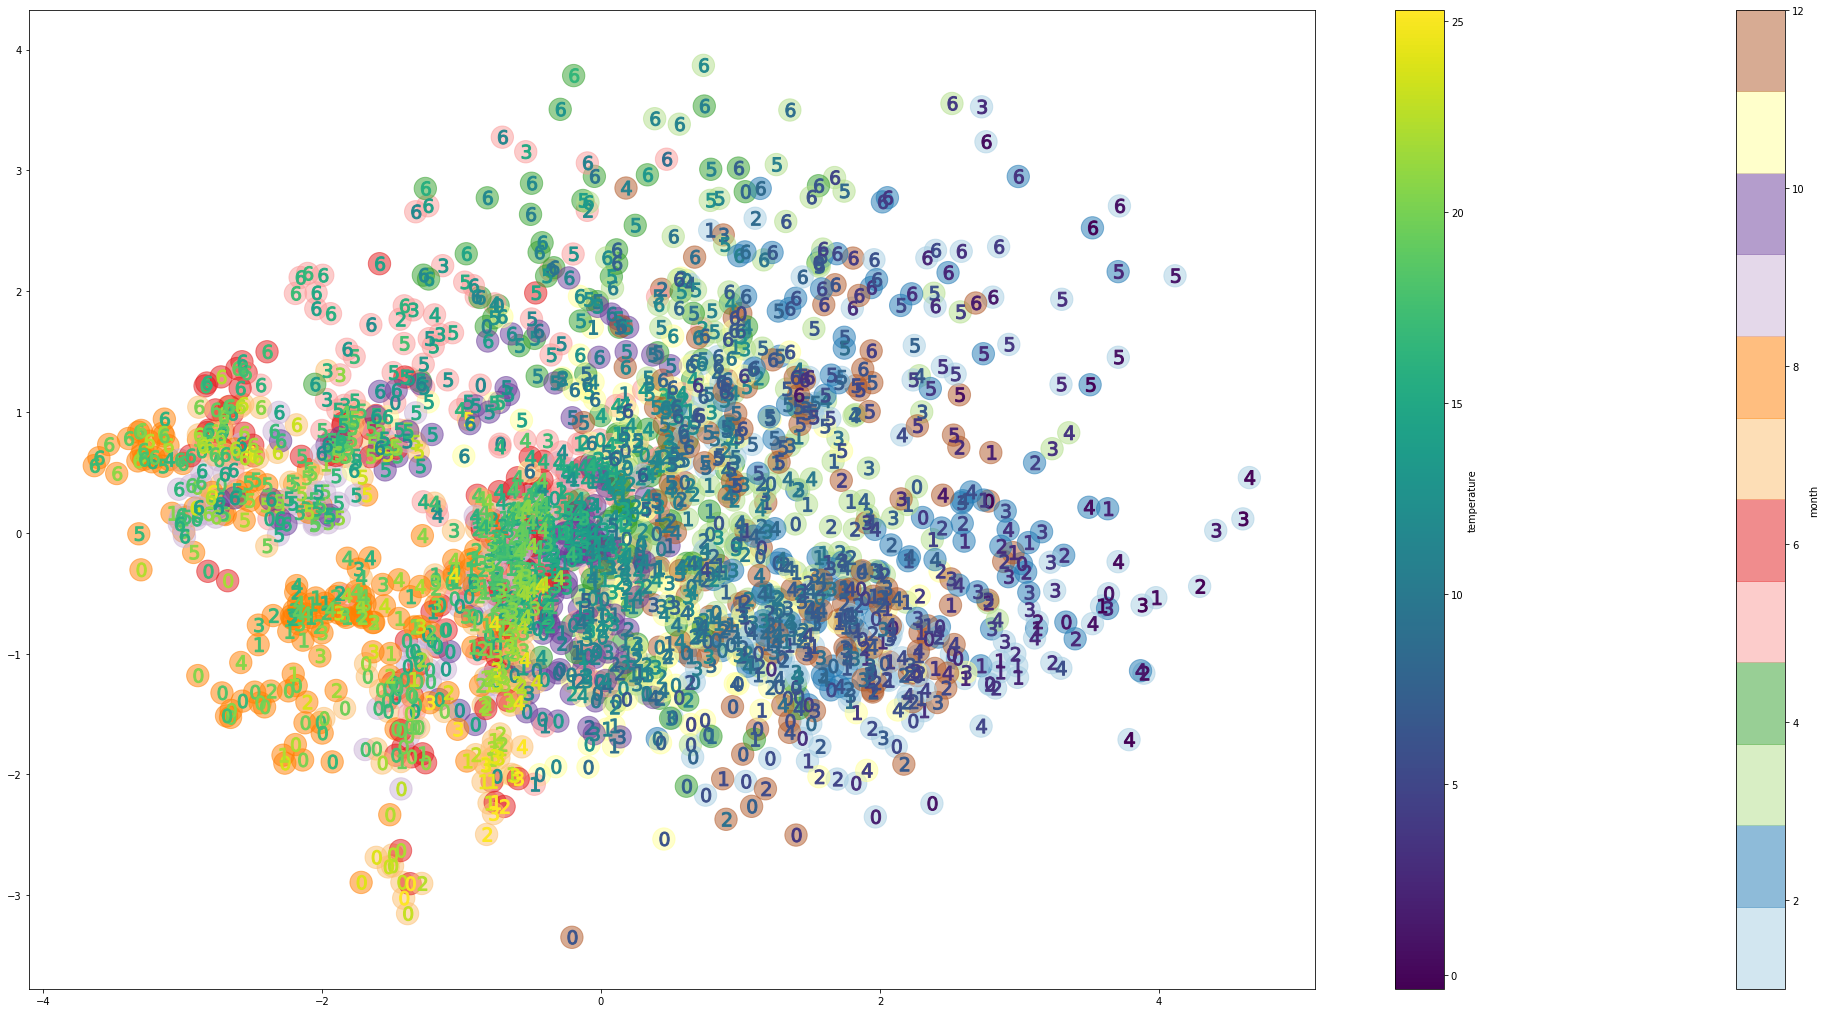

In [641]:
prez_2D(x_train_encoded, factorMatrix['train'])

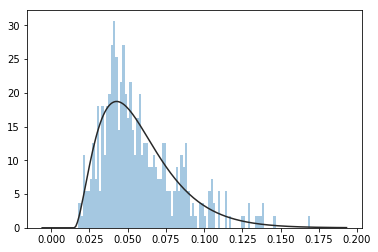

In [642]:
#calculer l'erreur de reconstruction
x = dataset_guided['test']['x'][0]
x_hat = guided_vae.cvae.predict(input_encoder)[0]
mae_error = np.mean(np.abs((x - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((x - x_hat)**2, axis=1)) / 48

#faire un histogramme des écarts
sn.distplot(mae_error, kde=False, fit=stats.beta, bins=100)

MAE : 749.90 MW


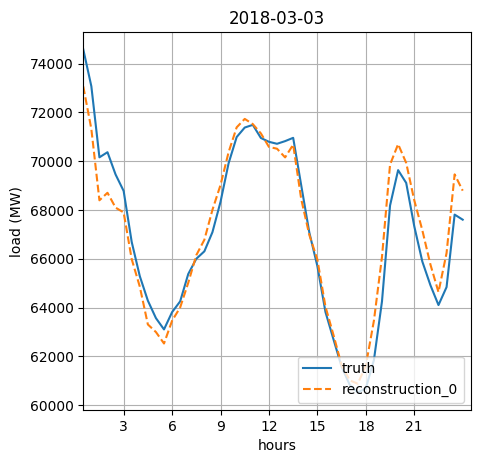

In [643]:
indice=61
display_loads([x[indice,:], x_hat[indice,:]], str(dataset_guided['test']['ds'].iloc[indice].date()), scaler=scaler)
print('MAE : %0.2f MW'%(np.mean(np.abs(scaler.inverse_transform(x[indice,:])- scaler.inverse_transform(x_hat[indice,:])))))

MAE : 735.67 MW


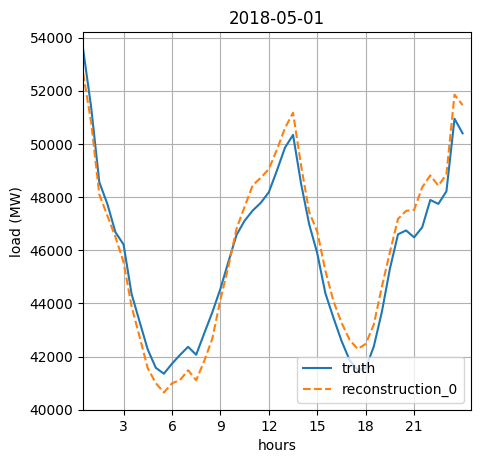

In [644]:
indice=120
display_loads([x[indice,:], x_hat[indice,:]], str(dataset_guided['test']['ds'].iloc[indice].date()), scaler=scaler)
print('MAE : %0.2f MW'%(np.mean(np.abs(scaler.inverse_transform(x[indice,:])- scaler.inverse_transform(x_hat[indice,:])))))

MAE : 873.93 MW


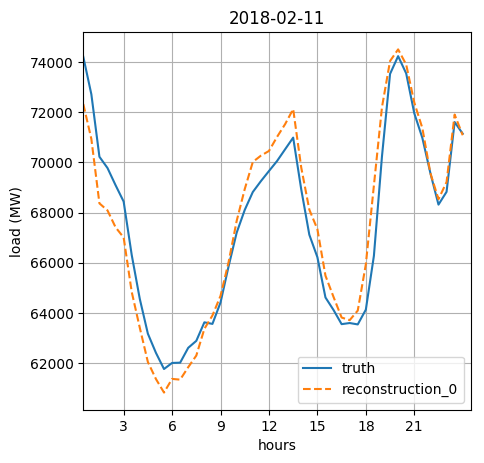

In [645]:
indice=61
display_loads([x[indice-20,:], x_hat[indice-20,:]], str(dataset_guided['test']['ds'].iloc[indice-20].date()), scaler=scaler)
print('MAE : %0.2f MW'%(np.mean(np.abs(scaler.inverse_transform(x[indice-20,:])- scaler.inverse_transform(x_hat[indice-20,:])))))

In [460]:
calendar_info['test'].iloc[indice-20]

ds                          2018-04-11 00:00:00
month                                         4
weekday                                       2
is_weekday                                    1
is_holiday_day                                0
year                                       2018
potential_bridge_holiday                      0
Name: 100, dtype: object

In [452]:
def unholy(input_dt,indice):
    return [item[indice,:].reshape(1,-1) for item in input_dt[:-1]]+[1-input_dt[-1][indice,:]]

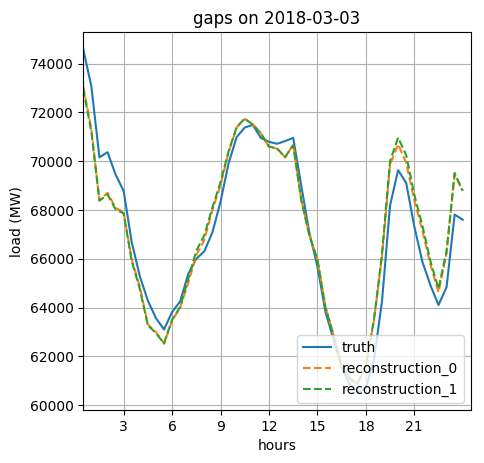

In [646]:
k=10000
prev = []
for k in range(k):
    prev.append(guided_vae.cvae.predict(unholy(dataset_guided['test']['x'], indice))[0][0])
x_hat_id = np.mean(np.asarray(prev),axis=0)

display_loads([x[indice,:], x_hat[indice,:],x_hat_id], 'gaps on '+str(dataset_guided['test']['ds'].iloc[indice].date()), scaler=scaler)

In [649]:
k=10000
prev = []
for k in range(k):
    prev.append(guided_vae.cvae.predict(unholy(dataset_guided['test']['x'], indice-20))[0][0])
x_hat_id = np.mean(np.asarray(prev),axis=0)

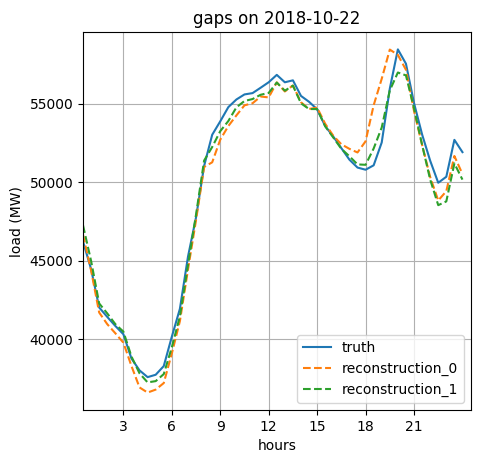

In [650]:
display_loads([x[indice-20,:], x_hat[indice-20,:],x_hat_id], 'gaps on '+str(dataset_guided['test']['ds'].iloc[indice-20].date()), scaler=scaler)

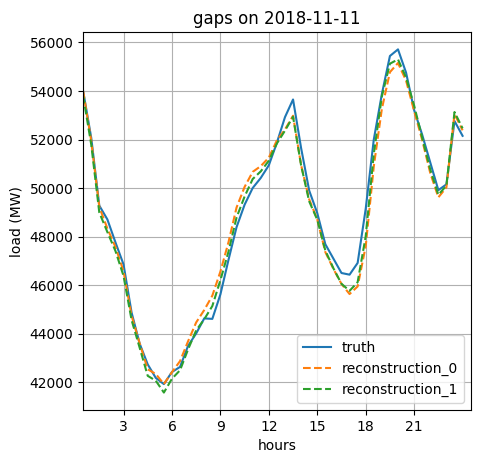

In [648]:
k=10000
indice = 314

prev = []
for k in range(k):
    prev.append(guided_vae.cvae.predict(unholy(dataset_guided['test']['x'], indice))[0][0])
x_hat_id = np.mean(np.asarray(prev),axis=0)

display_loads([x[indice,:], x_hat[indice,:],x_hat_id], 'gaps on '+str(dataset_guided['test']['ds'].iloc[indice].date()), scaler=scaler)

In [671]:
from keras.models import Model
guid_layer = Model(inputs=guided_vae.encoder.inputs, outputs=guided_vae.encoder.get_layer('latent_dense_mu_c_dim_4').output)
guid_layer_out = guid_layer.predict(dataset_guided['test']['x'])

In [676]:
guid_layer_out

array([[0.5822456 , 0.42915446, 0.46623442, 0.46159717],
       [0.5822456 , 0.42915446, 0.46623442, 0.46159717],
       [0.5822456 , 0.42915446, 0.46623442, 0.46159717],
       ...,
       [0.5822456 , 0.42915446, 0.46623442, 0.46159717],
       [0.5822456 , 0.42915446, 0.46623442, 0.46159717],
       [0.5822456 , 0.42915446, 0.46623442, 0.46159717]], dtype=float32)

In [673]:
holy_z_mu = Model(inputs=guided_vae.encoder.inputs, outputs=guided_vae.encoder.get_layer('latent_dense_mu_c_4').output)
holy_mu = holy_z_mu.predict(dataset_guided['test']['x'])

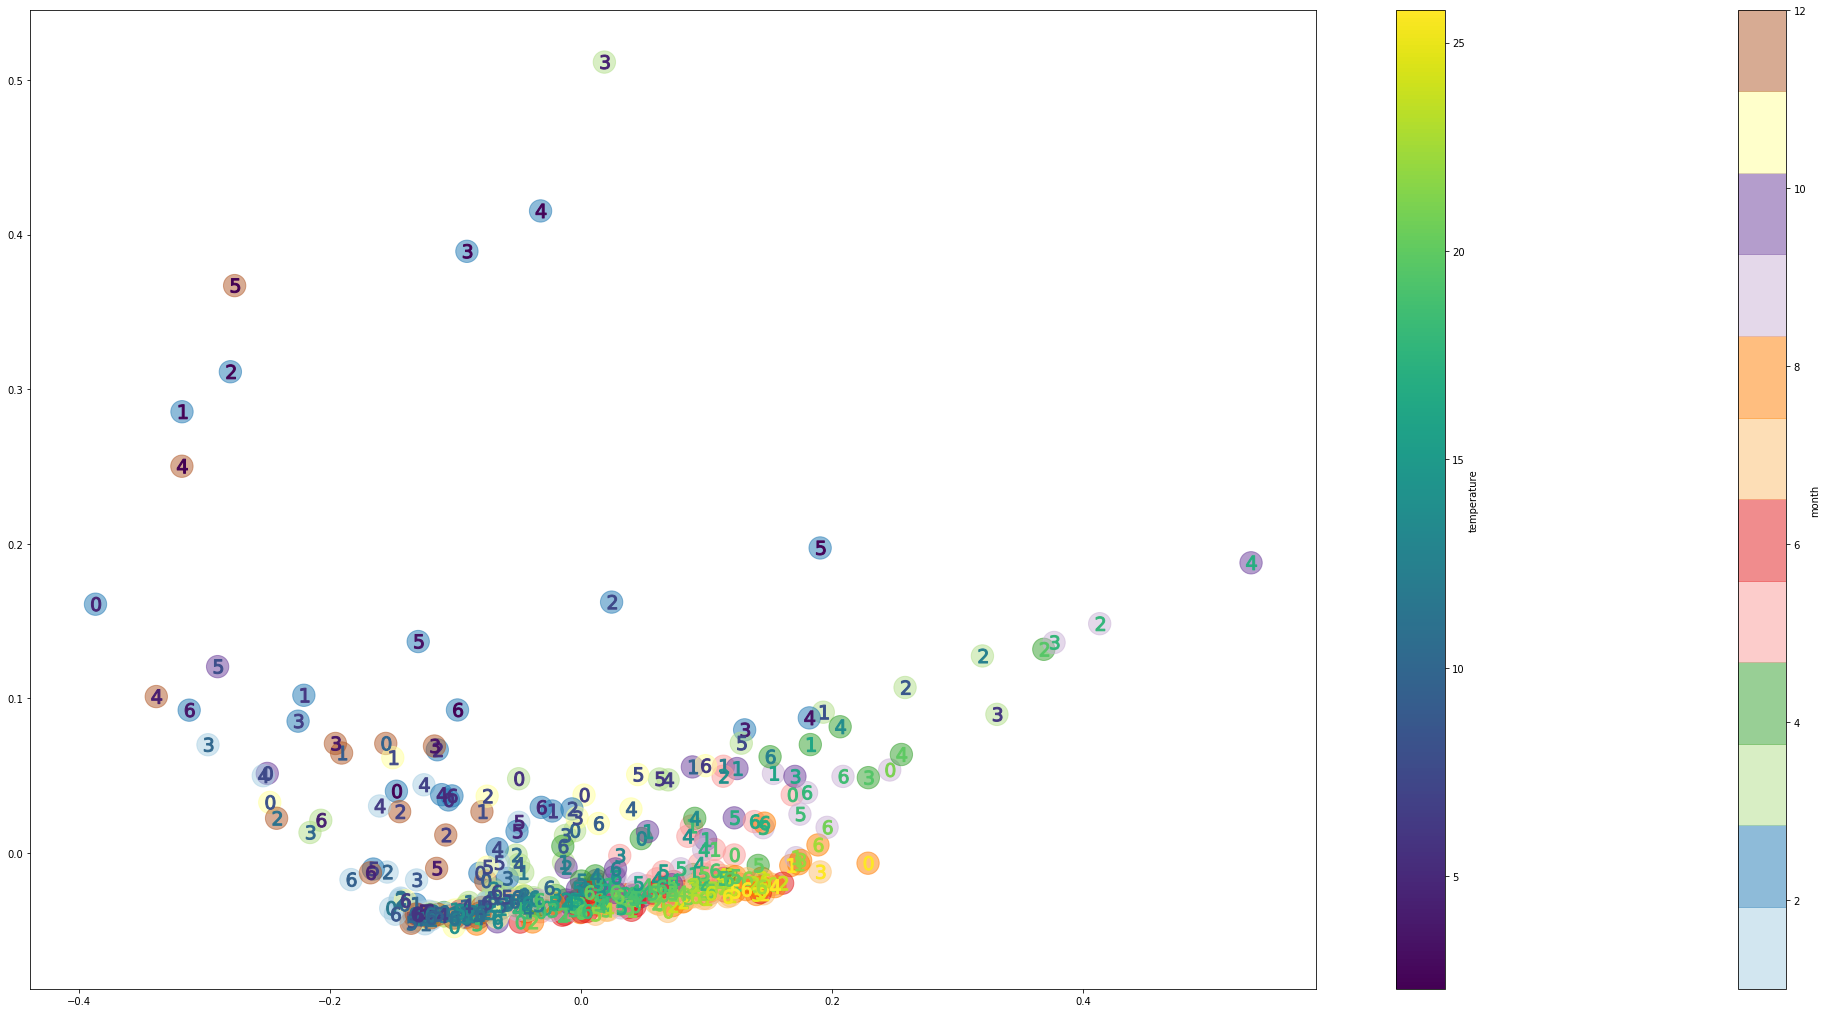

In [674]:
prez_2D(holy_mu, factorMatrix['test'])

Mutual Information Gap : 0.02


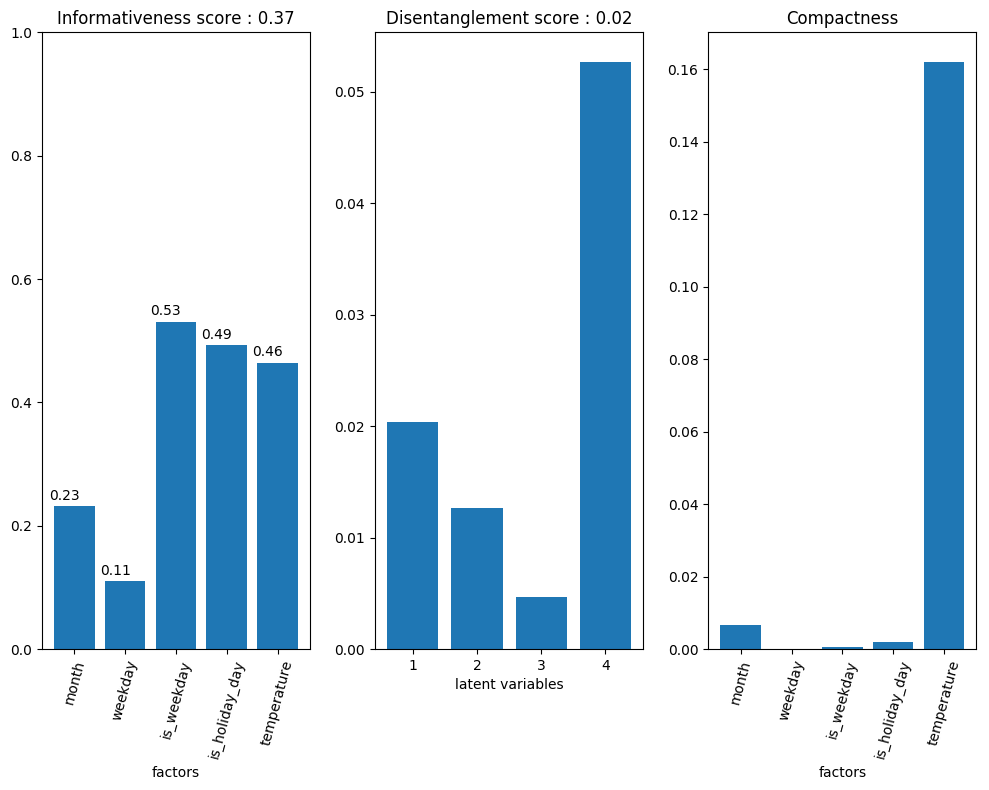

In [675]:
model_eval, importanceMatrix =evaluateLatentCode(holy_mu, factorMatrix['test'], factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)